%matplotlib inline
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.visualization import simple_norm
from astropy import wcs
from astropy import table
from astropy.io import fits
from astropy import units as u
import PIL
import regions
import pyavm
import numpy as np
import pylab as pl
pl.rcParams['figure.facecolor'] = 'w'
pl.rcParams['image.origin'] = 'lower'
pl.rcParams['figure.figsize'] = (10,8)
pl.rcParams['figure.dpi'] = 100
pl.rcParams['font.size'] = 16

In [1046]:
from astroquery.vizier import Vizier

In [1047]:
basepath = '/orange/adamginsburg/jwst/brick/'

In [1048]:
import sys, imp
sys.path.append(f'{basepath}/analysis/')
import plot_tools
imp.reload(plot_tools)
from plot_tools import starzoom, make_sed

In [1049]:
from plot_tools import starzoom, make_sed

In [1050]:
basetable = Table.read(f'{basepath}/catalogs/crowdsource_nsky0_merged_photometry_tables_merged.fits')

### DEbug

#maskf405n = basetable['mag_ab_f405n'].mask.copy()
#basetable['mag_ab_f405n'].mask[:] = False
maskf405n = np.isnan(basetable['mag_ab_f405n'])
basetable['mag_ab_f405n'][maskf405n]
flux = basetable['flux_f405n']
fwhm_arcsec = 0.136*u.arcsec
pxdg = u.Quantity(basetable.meta['405pxdg'], u.deg**2)
fwhm_pix = basetable['fwhm_f405n']
flux_jy = (u.Quantity(flux, u.MJy/u.sr) * (2*np.pi / (8*np.log(2))) * fwhm_pix**2 * pxdg).to(u.Jy)
abmag = flux_jy.to(u.ABmag)
abmag[maskf405n], flux_jy[maskf405n]

In [1051]:
filternames = ['f410m', 'f212n', 'f466n', 'f405n', 'f187n', 'f182m']

In [1052]:
any_saturated_ = [basetable[x] for x in basetable.colnames if 'near_sat' in x]
any_saturated = any_saturated_[0]
for row in any_saturated_[1:]:
    #print(row.sum())
    any_saturated = any_saturated | row
magerr_gtpt1 = np.logical_or.reduce([basetable[f'emag_ab_{filtername}'] > 0.2 for filtername in filternames])

In [1053]:
oksep = np.logical_or.reduce([basetable[f'sep_{filtername}'] for filtername in filternames[1:]])
blue_410_466 = oksep & ~any_saturated & (~(basetable['mag_ab_410m405'].mask)) & ((basetable['mag_ab_410m405'] - basetable['mag_ab_f466n']) + (basetable['emag_ab_f410m']**2 + basetable['emag_ab_f466n']**2 + basetable['emag_ab_f405n']**2)**0.5 < -1.75)
assert (blue_410_466 & basetable['mag_ab_410m405'].mask).sum() == 0
blue_410_405 = oksep & ~any_saturated & (~(basetable['mag_ab_410m405'].mask)) & ((basetable['mag_ab_410m405'] - basetable['mag_ab_f405n']) + (basetable['emag_ab_f410m']**2 + basetable['emag_ab_f405n']**2)**0.5 < -2)
blue_405_410 = oksep & ~any_saturated & (~(basetable['mag_ab_410m405'].mask)) & ((basetable['mag_ab_405m410'] - basetable['mag_ab_410m405']) + (basetable['emag_ab_f410m']**2 + basetable['emag_ab_f405n']**2)**0.5 < -3)
blue_405_410b = oksep & ~any_saturated & (basetable['flux_f405n'] > basetable['flux_f410m']) & (~(basetable['mag_ab_f405n'].mask)) & ((basetable['mag_ab_f405n'] - basetable['mag_ab_f410m']) + (basetable['emag_ab_f410m']**2 + basetable['emag_ab_f405n']**2)**0.5 < -2) & ~magerr_gtpt1

In [1054]:
blue_410_466.sum(), blue_405_410.sum(), blue_405_410b.sum()

(1007, 1796, 4125)

In [1055]:
viz = Vizier()

In [1056]:
bluetbl = basetable[blue_410_466]
bluetbl.sort('flux_f410m')
bluetbl[-5:]

<Table length=5>
     x_f410m            y_f410m       flux_f410m passno_f410m    dx_f410m      dy_f410m   dflux_f410m   qf_f410m   rchi2_f410m ... replaced_saturated_f182m flux_jy_410m405 mag_ab_410m405 flux_jy_405m410 mag_ab_405m410 flux_jy_182m187 mag_ab_182m187 flux_jy_187m182 mag_ab_187m182
                                                                                                                               ...                                 Jy                             Jy                             Jy                             Jy                     
     float64            float64        float32     float64       float32       float32      float32     float32      float32   ...           bool               float32        float32         float32        float32         float32        float32         float32        float32    
------------------ ------------------ ---------- ------------ ------------- ------------- ----------- ------------ ----------- ... ------------------------ --------------- -------------- --------------- -------------- --------------- -------------- --------------- --------------
2820.0014960726403 2293.0546800424922   76382.08          0.0  0.0038644252   0.004026979   130.10335   0.02549865   50003.117 ...                    False      0.07706219      11.682897     -0.06458749             --   -6.206108e-05             --   0.00042624364      17.325855
1550.9029048996115 2287.5701596316567   371050.3          0.0  0.0041963877   0.003415794     541.029 0.0017791213   131986.14 ...                    False      0.38648775        9.93216     -0.40065706             --   0.00040834735      17.372425   0.00023969437      17.950855
110.79141187667847  2107.429160386324  404166.47          0.0 0.00088193297  0.0008932613    128.1039  0.023314768  128387.555 ...                    False      0.41585433       9.852647     -0.39639014             --   0.00058878015      16.975117   1.1580589e-05      21.240673
2932.8489813655615  34.86459346115589   636060.7          0.0  0.0004696864 0.00038342565   136.62117   0.02381796     98724.9 ...                    False       0.6922646       9.299319       -0.903123             --    0.0005519113      17.045326    0.0076320143      14.193402
 1552.710868537426 2281.7366507947445  649344.44          0.0   0.000872484  0.0005820806   340.17804  0.005865639   134735.02 ...                    False       0.7403085       9.226468      -1.1619242             --   -0.0011190618             --     0.008063272      14.133721

In [1057]:
fov = regions.Regions.read(f'{basepath}/regions/nircam_fov.reg')

In [1058]:
coord = fov[0].center
height = fov[0].height
width = fov[0].width
height, width = width, height # CARTA wrote it wrong
coord, width, height

(<SkyCoord (ICRS): (ra, dec) in deg
     (266.53496367, -28.71007499)>,
 <Quantity 161.9038 arcsec>,
 <Quantity 391.024 arcsec>)

In [1059]:
skycrds_cat = bluetbl['skycoord_f410m']

In [1060]:
avm = pyavm.AVM.from_image(f'{basepath}/images/BrickSpitzer_RGB_I421.png')
wwi_spitzer_unflip = wcs.WCS(fits.Header.fromstring(avm.Spatial.FITSheader))

Set DATE-AVG to '2022-08-28T03:05:32.473' from MJD-AVG.
Set DATE-END to '2022-08-28T03:34:03.557' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -20.651775 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526292809.682 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [1180]:
spitzer = Vizier(row_limit=1e6).query_region(coordinates=coord, width=width*2, height=height*2, catalog=['II/295/SSTGC'])[0]
spitzer.add_index('SSTGC')
spitzer_crds = SkyCoord(spitzer['RAJ2000'], spitzer['DEJ2000'], frame='fk5', unit=(u.hour, u.deg))
spitzer.add_column(col=spitzer_crds, name='coordinates')
assert len(spitzer) > 1
spitzer.write('/orange/adamginsburg/spitzer/cmz_catalog_II_295_SSTGC_Ramirez2008.fits', overwrite=True)

spitzer_crds_in_field = wwi_spitzer_unflip.footprint_contains(spitzer_crds)
spitzer = spitzer[spitzer_crds_in_field]
spitzer_crds = spitzer_crds[spitzer_crds_in_field]
idx, sidx, sep, sep3d = spitzer_crds.search_around_sky(skycrds_cat, 1*u.arcsec)
len(spitzer), len(idx), len(sidx)

(1169, 8928, 8928)

/scratch/local/54461384/ipykernel_55608/1515990771.py:1: UserWarning: You passed a edgecolor/edgecolors ('b') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  pl.scatter(spitzer_crds.ra[sidx], spitzer_crds.dec[sidx], facecolor='b', edgecolor='b', marker='x')


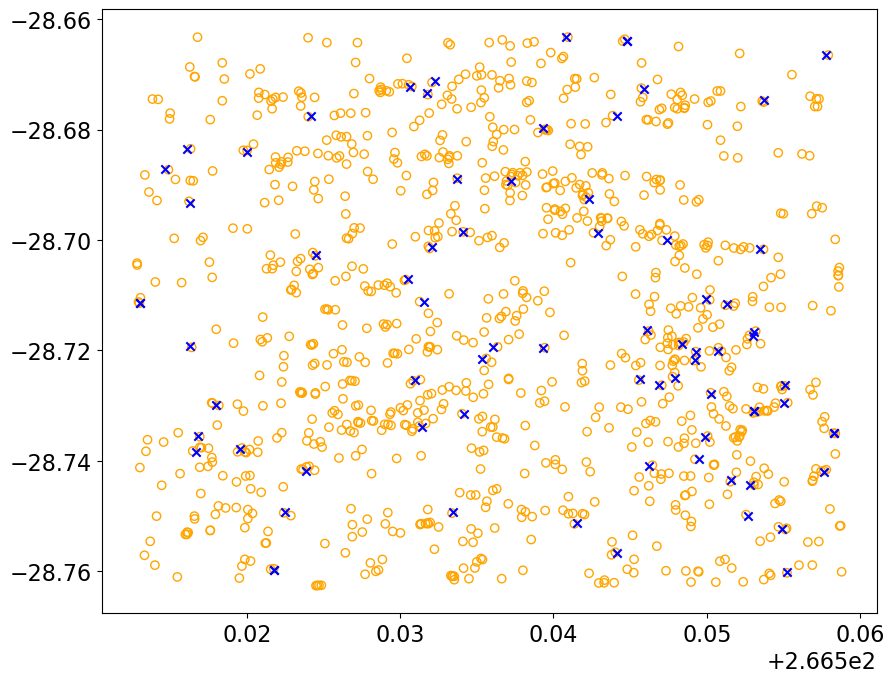

In [1062]:
pl.scatter(spitzer_crds.ra[sidx], spitzer_crds.dec[sidx], facecolor='b', edgecolor='b', marker='x')
pl.scatter(skycrds_cat.ra, skycrds_cat.dec, facecolor='none', edgecolor='orange', zorder=-5)

Set OBSGEO-B to   -20.631897 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526059356.900 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


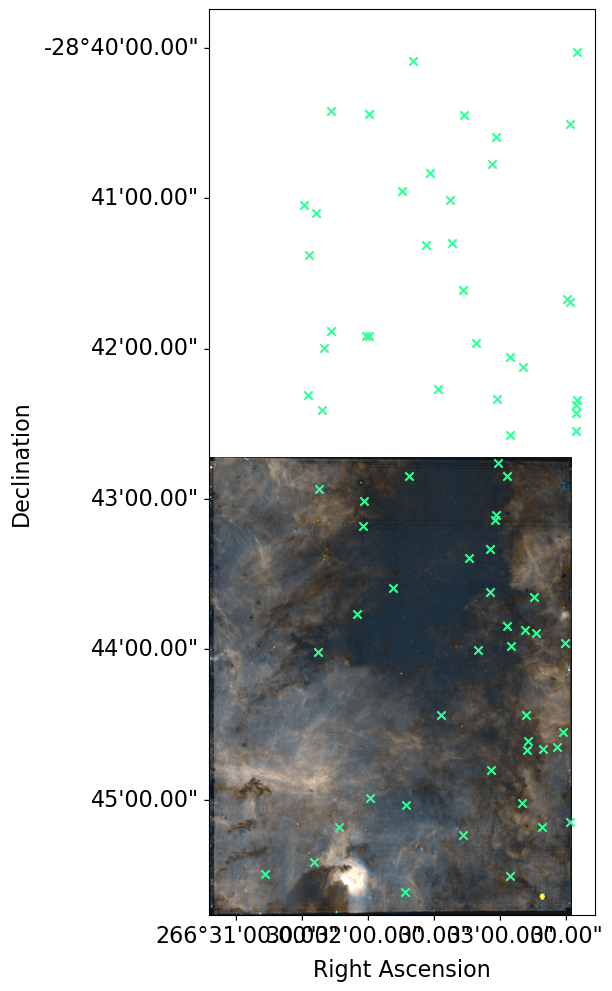

In [1063]:
# This image shows only H-alpha stars
avm = pyavm.AVM.from_image(f'{basepath}/images/BrickJWST_nrca_longwave_narrowband_rotated_lighter.png')
img_narrow = np.array(PIL.Image.open(f'{basepath}/images/BrickJWST_nrca_longwave_narrowband_rotated_lighter.png'))[::-1,:,:]
#wwi_bra_410 = avm.to_wcs(use_full_header=True)
wwi_narrow = wcs.WCS(fits.Header.fromstring(avm.Spatial.FITSheader))

img_narrow = img_narrow.swapaxes(0,1)
wwi_narrow = wwi_narrow.sub([2,1])

fig = pl.figure(figsize=(12,12))
ax = pl.subplot(projection=wwi_narrow)
ax.imshow(img_narrow)

crds = basetable['skycoord_f410m']
ax.scatter(
    crds.dec[blue_410_466][idx],
    crds.ra[blue_410_466][idx],
    transform=ax.get_transform('world'),
    marker='x', facecolors=(0.2, 1, 0.6),
    #markeredgewidth=0.5,
    # for non-x facecolors='none'
    #edgecolors=(0.3, 0.5, 0.8), 
);
#ax.scatter(crds.ra[blue_410_405], crds.dec[blue_410_405], edgecolors='orange', facecolors='none', transform=ax.get_transform('world'))
ax.coords['ra'].set_axislabel('Right Ascension')
ax.coords['dec'].set_axislabel('Declination')

ra = lon = ax.coords['ra']
dec = lat = ax.coords['dec']
lon.set_major_formatter('dd:mm:ss.ss')
lat.set_major_formatter('dd:mm:ss.ss')
#lon.set_ticks(spacing=30. * u.arcsec, color='red')
#lat.set_ticks(spacing=30. * u.arcsec, color='blue')
#lon.set_ticklabel(color='red')
#lat.set_ticklabel(color='blue')
#lon.grid(color='red')
#lat.grid(color='blue')

dec.set_ticks_position('l')
dec.set_ticklabel_position('l')
dec.set_axislabel_position('l')
ra.set_ticks_position('b')
ra.set_ticklabel_position('b')
ra.set_axislabel_position('b')
#fig.savefig(f"{basepath}/images/BlueStarsWithSpitzerMatches_on_RGB.png", bbox_inches='tight')

Set DATE-AVG to '2022-08-28T03:05:32.473' from MJD-AVG.
Set DATE-END to '2022-08-28T03:34:03.557' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -20.651775 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526292809.682 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


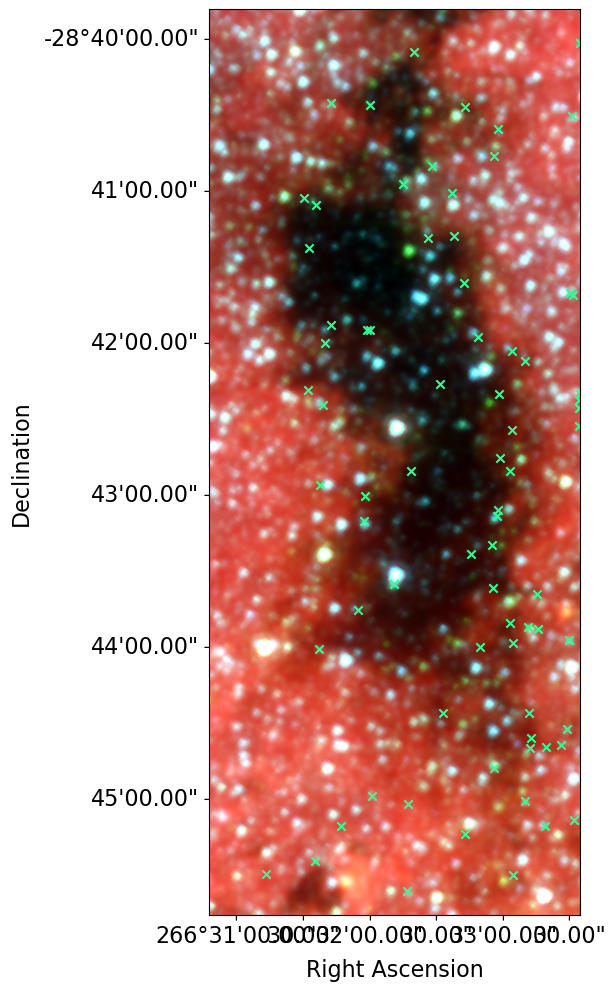

In [1064]:
avm = pyavm.AVM.from_image(f'{basepath}/images/BrickSpitzer_RGB_I421.png')
img_spitzer = np.array(PIL.Image.open(f'{basepath}/images/BrickSpitzer_RGB_I421.png'))[::-1,:,:]
wwi_spitzer_unflip = wcs.WCS(fits.Header.fromstring(avm.Spatial.FITSheader))

img_spitzer = img_spitzer.swapaxes(0,1)
wwi_spitzer = wwi_spitzer_unflip.sub([2,1])

fig = pl.figure(figsize=(12,12))
ax = pl.subplot(projection=wwi_spitzer)
ax.imshow(img_spitzer)

crds = basetable['skycoord_f410m']
ax.scatter(
    crds.dec[blue_410_466][idx],
    crds.ra[blue_410_466][idx],
    transform=ax.get_transform('world'),
    marker='x', facecolors=(0.2, 1, 0.6),
    #markeredgewidth=0.5,
    # for non-x facecolors='none'
    #edgecolors=(0.3, 0.5, 0.8), 
);
#ax.scatter(crds.ra[blue_410_405], crds.dec[blue_410_405], edgecolors='orange', facecolors='none', transform=ax.get_transform('world'))
ax.coords['ra'].set_axislabel('Right Ascension')
ax.coords['dec'].set_axislabel('Declination')

ra = lon = ax.coords['ra']
dec = lat = ax.coords['dec']
lon.set_major_formatter('dd:mm:ss.ss')
lat.set_major_formatter('dd:mm:ss.ss')
#lon.set_ticks(spacing=30. * u.arcsec, color='red')
#lat.set_ticks(spacing=30. * u.arcsec, color='blue')
#lon.set_ticklabel(color='red')
#lat.set_ticklabel(color='blue')
#lon.grid(color='red')
#lat.grid(color='blue')

dec.set_ticks_position('l')
dec.set_ticklabel_position('l')
dec.set_axislabel_position('l')
ra.set_ticks_position('b')
ra.set_ticklabel_position('b')
ra.set_axislabel_position('b')
#fig.savefig(f"{basepath}/images/BlueStarsWithSpitzerMatches_on_RGB.png", bbox_inches='tight')

In [1065]:
spitzer[:3]

<Table length=3>
 SSTGC    RAJ2000     DEJ2000     Jmag    Hmag    Ksmag   _3.6mag _4.5mag _5.8mag _8.0mag IRAC _2M               coordinates             
          'h:m:s'     'd:m:s'     mag     mag      mag      mag     mag     mag     mag                            deg,deg               
  str7     str11       str11    float32 float32  float32  float32 float32 float32 float32 str4 str2                SkyCoord              
------- ----------- ----------- ------- -------- -------- ------- ------- ------- ------- ---- ---- -------------------------------------
0587868 17 46 02.85 -28 40 12.2  16.356   12.092   10.268   8.880   8.877   8.521   8.613 IRAC   2M        266.511875,-28.670055555555557
0587987 17 46 02.88 -28 40 56.9      --       --       --  11.862  11.750  11.650      -- IRAC   2M           266.512,-28.682472222222223
0588048 17 46 02.91 -28 41 10.7  16.354   13.242   11.082   9.990   9.987   9.204   8.947 IRAC   2M 266.5121249999999,-28.686305555555556

Text(0, 0.5, 'I2-I4')

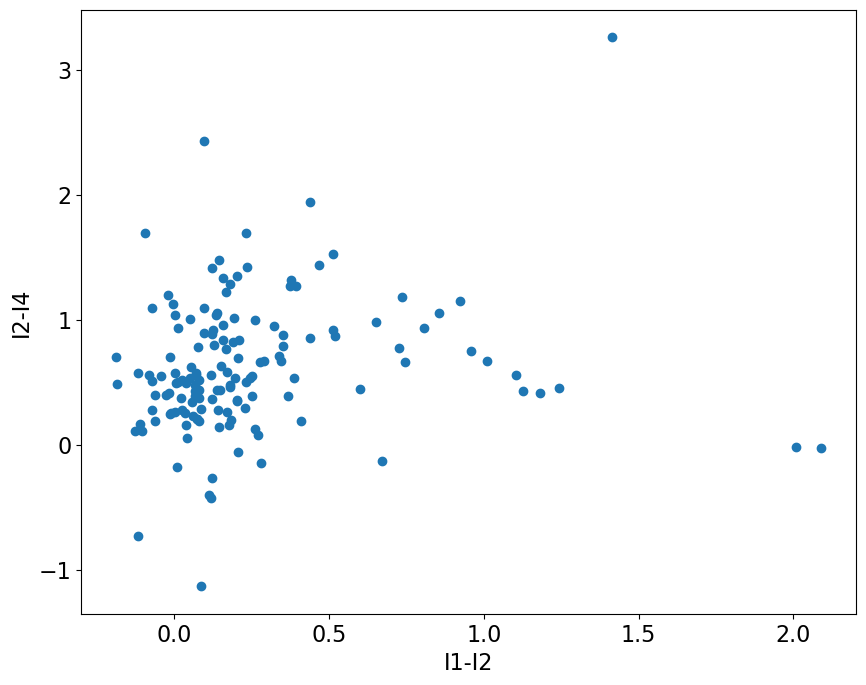

In [1066]:
pl.scatter(spitzer['_3.6mag'] - spitzer['_4.5mag'],  spitzer['_4.5mag'] - spitzer['_8.0mag'])
pl.xlabel("I1-I2")
pl.ylabel("I2-I4")

Text(0, 0.5, 'I2')

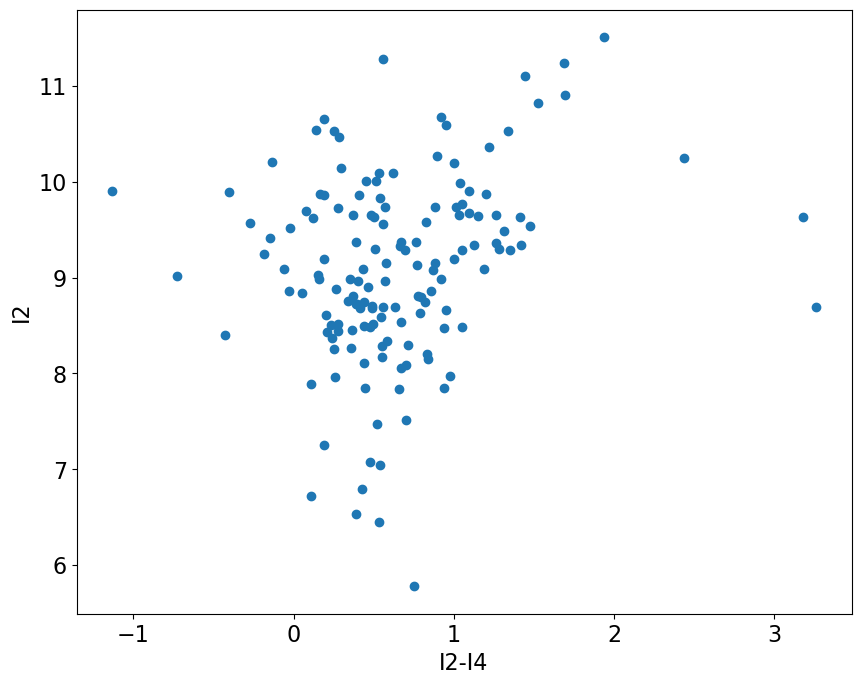

In [1067]:
pl.scatter(spitzer['_4.5mag'] - spitzer['_8.0mag'],  spitzer['_4.5mag'])
pl.xlabel("I2-I4")
pl.ylabel("I2")

Text(0, 0.5, 'I2-I4')

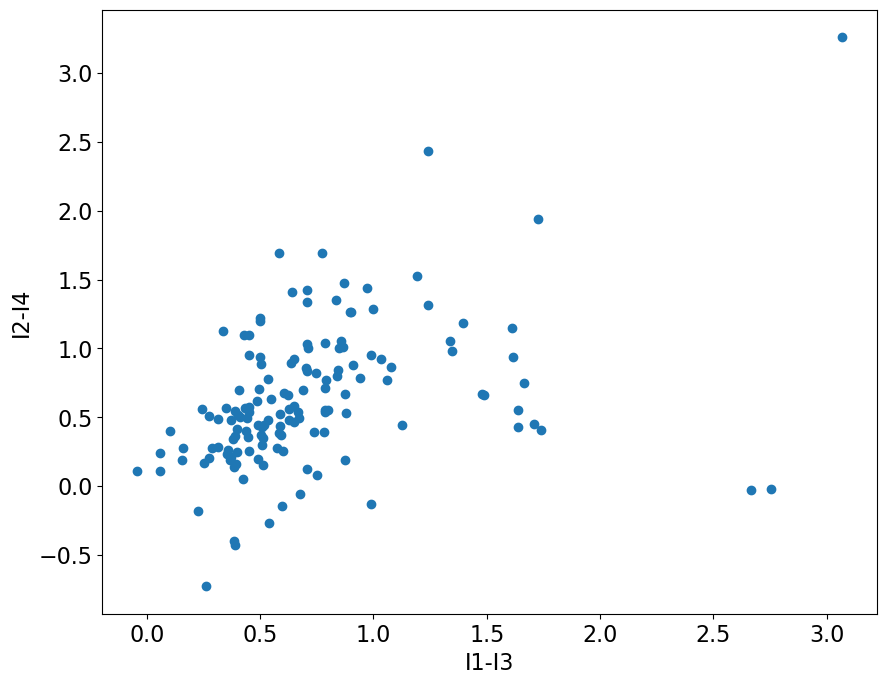

In [1068]:
pl.scatter(spitzer['_3.6mag'] - spitzer['_5.8mag'],  spitzer['_4.5mag'] - spitzer['_8.0mag'])
pl.xlabel("I1-I3")
pl.ylabel("I2-I4")

In [1069]:
wwi_spitzer.world_to_pixel(spitzer_crds[spitzer['_4.5mag'] - spitzer['_8.0mag'] < 0])

(array([  6.94763763,  26.45448607,  20.32406318,  40.98150225,
        196.08575698, 277.73480409, 315.53324653, 398.56227853,
        446.52683274, 463.78622616, 515.68907643]),
 array([ 662.57186034,  778.95768184,  199.61880154, 1326.42026218,
         156.87255305,  137.76951954, 1040.47277236,  767.74140476,
         287.58311956,   52.36904822, 1117.56988696]))

Set DATE-AVG to '2022-08-28T03:05:32.473' from MJD-AVG.
Set DATE-END to '2022-08-28T03:34:03.557' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -20.651775 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526292809.682 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


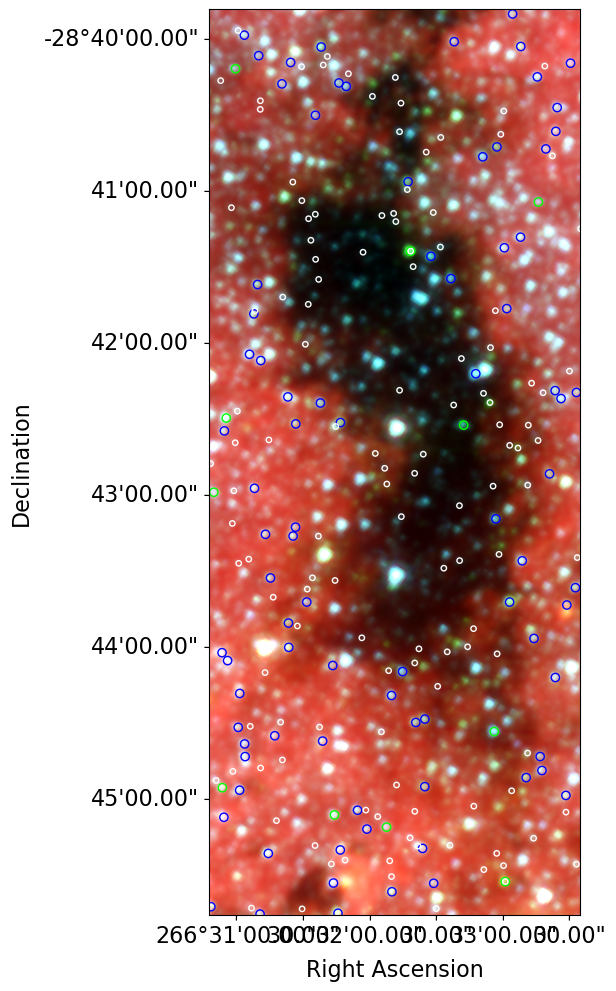

In [1070]:
# This image shows only H-alpha stars
avm = pyavm.AVM.from_image(f'{basepath}/images/BrickSpitzer_RGB_I421.png')
img_spitzer = np.array(PIL.Image.open(f'{basepath}/images/BrickSpitzer_RGB_I421.png'))[::-1,:,:]
#wwi_bra_410 = avm.to_wcs(use_full_header=True)
wwi_spitzer_unflip = wcs.WCS(fits.Header.fromstring(avm.Spatial.FITSheader))

img_spitzer = img_spitzer.swapaxes(0,1)
wwi_spitzer = wwi_spitzer_unflip.sub([2,1])

fig = pl.figure(figsize=(12,12))
ax = pl.subplot(projection=wwi_spitzer)
ax.imshow(img_spitzer)
axlims = ax.axis()

green_spitzer = (spitzer['_4.5mag'] - spitzer['_8.0mag'] < 0.)
green_nored = ((spitzer['_4.5mag'] < 10) & (spitzer['_8.0mag'].mask))
xx,yy = wwi_spitzer.world_to_pixel(spitzer_crds[green_spitzer])
ax.scatter(
    xx,yy,
    #spitzer_crds.ra[spitzer['_4.5mag'] - spitzer['_8.0mag'] < 0],
    #spitzer_crds.dec[spitzer['_4.5mag'] - spitzer['_8.0mag'] < 0],
    #transform=ax.get_transform('fk5'),
    marker='o', edgecolors='lime', facecolors='none',
    #markeredgewidth=0.5,
    # for non-x facecolors='none'
    #edgecolors=(0.3, 0.5, 0.8), a 
);
xx,yy = wwi_spitzer.world_to_pixel(spitzer_crds[green_nored])
ax.scatter(
    xx,yy,
    marker='o', edgecolors='b', facecolors='none',
);
redi1i2_spitzer = (spitzer['_3.6mag'] - spitzer['_4.5mag'] > 1.75)# | ((10 < spitzer['_4.5mag']) & (spitzer['_4.5mag'] < 15) & (spitzer['_8.0mag'].mask))
xx,yy = wwi_spitzer.world_to_pixel(spitzer_crds[redi1i2_spitzer])
ax.scatter(
    xx,yy,
    #spitzer_crds.ra[spitzer['_4.5mag'] - spitzer['_8.0mag'] < 0],
    #spitzer_crds.dec[spitzer['_4.5mag'] - spitzer['_8.0mag'] < 0],
    #transform=ax.get_transform('fk5'),
    marker='o', edgecolors='w', facecolors='none',
s=15,
    # for non-x facecolors='none'
    #edgecolors=(0.3, 0.5, 0.8), a 
);
#ax.scatter(crds.ra[blue_410_405], crds.dec[blue_410_405], edgecolors='orange', facecolors='none', transform=ax.get_transform('world'))
ax.coords['ra'].set_axislabel('Right Ascension')
ax.coords['dec'].set_axislabel('Declination')

ra = lon = ax.coords['ra']
dec = lat = ax.coords['dec']
lon.set_major_formatter('dd:mm:ss.ss')
lat.set_major_formatter('dd:mm:ss.ss')
#lon.set_ticks(spacing=30. * u.arcsec, color='red')
#lat.set_ticks(spacing=30. * u.arcsec, color='blue')
#lon.set_ticklabel(color='red')
#lat.set_ticklabel(color='blue')
#lon.grid(color='red')
#lat.grid(color='blue')

ax.axis(axlims)

dec.set_ticks_position('l')
dec.set_ticklabel_position('l')
dec.set_axislabel_position('l')
ra.set_ticks_position('b')
ra.set_ticklabel_position('b')
ra.set_axislabel_position('b')
#fig.savefig(f"{basepath}/images/BlueStarsWithSpitzerMatches_on_RGB.png", bbox_inches='tight')

In [1071]:
coord = SkyCoord('17:46:08.914 -28:41:22.51', frame='fk5', unit=(u.hour, u.deg))
radius = 0.5*u.arcsec

<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    (266.53714167, -28.68958611)>

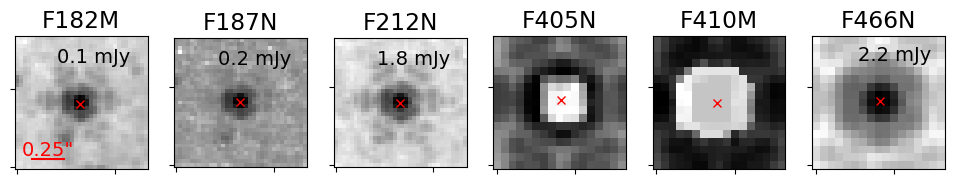

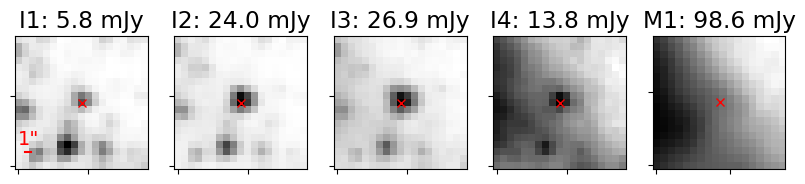

In [1072]:
import sys, imp
sys.path.append(f'{basepath}/analysis/')
sys.path.append(f'{basepath}/reduction/')
import plot_tools
imp.reload(plot_tools)
from plot_tools import starzoom, make_sed, starzoom_spitzer
starzoom(coord)
starzoom_spitzer(coord)
coord

In [1073]:
(coord.separation(skycrds_cat) < radius).sum()

0

In [1178]:
coord = SkyCoord('17:46:08.914 -28:41:22.51', frame='fk5', unit=(u.hour, u.deg))
radius = 0.5*u.arcsec

skycrds_cat = basetable['skycoord_f410m']
idx = coord.separation(skycrds_cat) < radius
if len(idx) == 0:
    raise

spitzer_ = Vizier.query_region(coordinates=coord, radius=radius, catalog=['II/295/SSTGC'])[0]
if len(spitzer) > 0:
    spitzer_crds = SkyCoord(spitzer_['RAJ2000'], spitzer_['DEJ2000'], frame='fk5', unit=(u.hour, u.deg))
    spitzindex = coord.separation(spitzer_crds) < radius
    print(len(spitzindex))
    spitzermatch = spitzer_[spitzindex]

vvvdr2 = Vizier.query_region(coordinates=coord, radius=0.5*u.arcsec, catalog=['II/348/vvv2'])[0]
if len(spitzer) > 0:
    vvvdr2_crds = SkyCoord(vvvdr2['RAJ2000'], vvvdr2['DEJ2000'], frame='fk5', unit=(u.hour, u.deg))
    vvvindex = coord.separation(vvvdr2_crds) < radius
    print(len(vvvindex))
    vvvmatch = vvvdr2[vvvindex]

1
1


In [1075]:
from astroquery.svo_fps import SvoFps

In [1076]:
for filtername in filternames:
    telescope = 'JWST'
    instrument = 'NIRCAM'
    wavelength_table = SvoFps.get_transmission_data(f'{telescope}/{instrument}.{filtername}')

In [1077]:
spitzer[:1]

<Table length=1>
 SSTGC    RAJ2000     DEJ2000     Jmag    Hmag    Ksmag   _3.6mag _4.5mag _5.8mag _8.0mag IRAC _2M 
          'h:m:s'     'd:m:s'     mag     mag      mag      mag     mag     mag     mag            
  str7     str11       str11    float32 float32  float32  float32 float32 float32 float32 str4 str2
------- ----------- ----------- ------- -------- -------- ------- ------- ------- ------- ---- ----
0604691 17 46 08.93 -28 41 22.5  15.819   14.663   12.374  10.953   8.864   8.285   8.895 IRAC   2M

In [1078]:
    skycrds_cat = basetable['skycoord_f410m']
    idx = coord.separation(skycrds_cat) < radius
    if len(idx) == 0:
        raise
    else:
        idx = np.argmin(coord.separation(skycrds_cat))

    spitzer_this = Vizier.query_region(coordinates=coord, radius=radius, catalog=['II/295/SSTGC'])[0]
    if len(spitzer) > 0:
        spitzer_crds = SkyCoord(spitzer_this['RAJ2000'], spitzer_this['DEJ2000'], frame='fk5', unit=(u.hour, u.deg))
        spitzindex = coord.separation(spitzer_crds) < radius
        print(len(spitzindex))
        spitzermatch = spitzer_this[spitzindex]

    vvvdr2 = Vizier.query_region(coordinates=coord, radius=0.5*u.arcsec, catalog=['II/348/vvv2'])[0]
    if len(spitzer) > 0:
        vvvdr2_crds = SkyCoord(vvvdr2['RAJ2000'], vvvdr2['DEJ2000'], frame='fk5', unit=(u.hour, u.deg))
        vvvindex = coord.separation(vvvdr2_crds) < radius
        print(len(vvvindex))
        vvvmatch = vvvdr2[vvvindex]

    wavelengths = []
    fluxes = []
    widths = []
    telescope = 'JWST'
    instrument = 'NIRCAM'
    filter_table = SvoFps.get_filter_list(facility=telescope, instrument=instrument)
    filter_table.add_index('filterID')
    for filtername in filternames:
        instrument = 'NIRCam'
        filtername = filtername.upper()
        eff_wavelength = filter_table.loc[f'{telescope}/{instrument}.{filtername}']['WavelengthEff'] * u.AA
        wavelengths.append(eff_wavelength)
        eff_width = filter_table.loc[f'{telescope}/{instrument}.{filtername}']['WidthEff'] * u.AA
        widths.append(eff_width)
        filtername = filtername.lower()
        fluxes.append(basetable[f'flux_jy_{filtername}'][idx] * u.Jy)


    telescope = 'Spitzer'
    instrument = 'IRAC'
    filter_table = SvoFps.get_filter_list(facility=telescope, instrument=instrument)
    filter_table.add_index('filterID')
    for filtername,colname in [('I1', '_3.6mag'),
                               ('I2', '_4.5mag'),
                               ('I3', '_5.8mag'),
                               ('I4', '_8.0mag')]:
        eff_wavelength = filter_table.loc[f'{telescope}/{instrument}.{filtername}']['WavelengthEff'] * u.AA
        wavelengths.append(eff_wavelength)
        fluxes.append(10**(-spitzer[colname]/2.5) * filter_table.loc[f'{telescope}/{instrument}.{filtername}']['ZeroPoint'] * u.Jy)
        eff_width = filter_table.loc[f'{telescope}/{instrument}.{filtername}']['WidthEff'] * u.AA
        widths.append(eff_width)

1
1


In [1079]:
filternames

['f410m', 'f212n', 'f466n', 'f405n', 'f187n', 'f182m']

In [1080]:
fluxes, widths

([<Quantity 0.13719383 Jy>,
  <Quantity 0.02637436 Jy>,
  <Quantity 0.04736515 Jy>,
  <Quantity -0.00839414 Jy>,
  <Quantity 0.00204083 Jy>,
  <Quantity 0.00167842 Jy>,
  <Quantity [0.01141275] Jy>,
  <Quantity [0.05058216] Jy>,
  <Quantity [0.05510747] Jy>,
  <Quantity [0.01762665] Jy>],
 [<Quantity 4262.85790239 Angstrom>,
  <Quantity 274.27440341 Angstrom>,
  <Quantity 535.40523943 Angstrom>,
  <Quantity 454.87184789 Angstrom>,
  <Quantity 236.68645057 Angstrom>,
  <Quantity 2250.8124937 Angstrom>,
  <Quantity 6836.18018646 Angstrom>,
  <Quantity 8649.92060205 Angstrom>,
  <Quantity 12561.17490202 Angstrom>,
  <Quantity 25288.49843082 Angstrom>])

/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/astropy/units/quantity.py:502: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  value = np.array(value, dtype=dtype, copy=copy, order=order,


<ErrorbarContainer object of 3 artists>

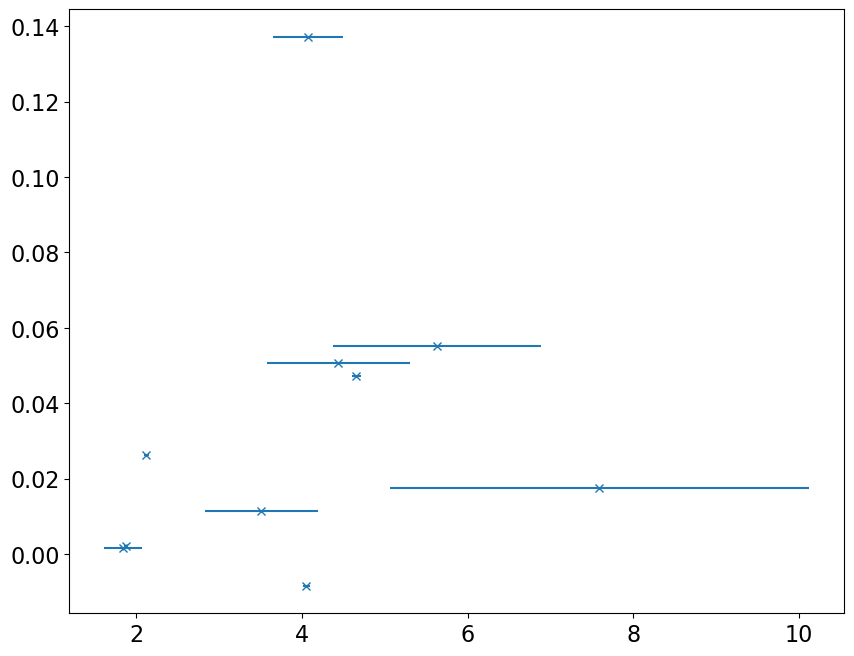

In [1081]:
pl.errorbar(u.Quantity(wavelengths, u.um), u.Quantity([u.Quantity(x, u.Jy) for x in fluxes], u.Jy), xerr=widths, linestyle='none', marker='x')

# TODO: figure out where the green spitzer sources are

and what they are


Are they 4.5 micron excess?

5-8 micron dropout?

what?

In [1082]:
bright_green_star_list = ['0604691', '0608824', '0611502', '0613733', '0611429', '0612623', '0613626', '0612695']

In [1083]:
spitzer.add_index('SSTGC')

In [1084]:
selind = spitzer.loc[bright_green_star_list[0]]
selind

<Row index=0>
 SSTGC    RAJ2000     DEJ2000     Jmag    Hmag    Ksmag   _3.6mag _4.5mag _5.8mag _8.0mag IRAC _2M 
          'h:m:s'     'd:m:s'     mag     mag      mag      mag     mag     mag     mag            
  str7     str11       str11    float32 float32  float32  float32 float32 float32 float32 str4 str2
------- ----------- ----------- ------- -------- -------- ------- ------- ------- ------- ---- ----
0604691 17 46 08.93 -28 41 22.5  15.819   14.663   12.374  10.953   8.864   8.285   8.895 IRAC   2M

In [1085]:
from astropy.coordinates import SkyCoord

/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/astropy/units/quantity.py:502: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  value = np.array(value, dtype=dtype, copy=copy, order=order,


Text(0.5, 1.0, '0604691')

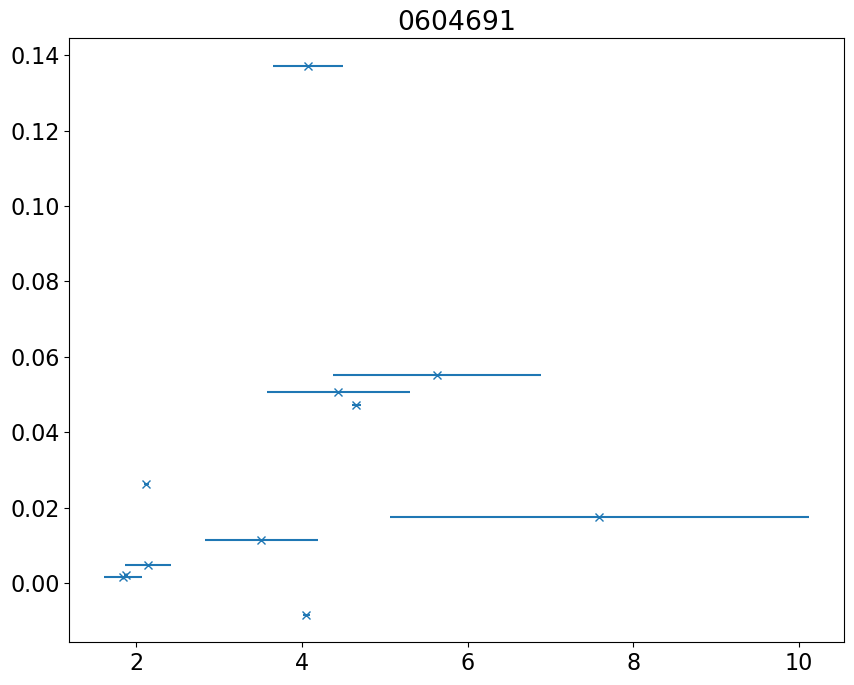

In [1087]:
starid = bright_green_star_list[0]
selstar = spitzer.loc[starid]
coord = SkyCoord(selstar['RAJ2000'], selstar['DEJ2000'], frame='fk5', unit=(u.h, u.deg))
wavelengths, widths, fluxes, lims = make_sed(coord, basetable=basetable, radius=1*u.arcsec)
pl.errorbar(u.Quantity(wavelengths, u.um), u.Quantity([u.Quantity(x, u.Jy) for x in fluxes], u.Jy), xerr=widths, linestyle='none', marker='x')
pl.title(starid)

In [1088]:
widths

[<Quantity 4262.85790239 Angstrom>,
 <Quantity 274.27440341 Angstrom>,
 <Quantity 535.40523943 Angstrom>,
 <Quantity 454.87184789 Angstrom>,
 <Quantity 236.68645057 Angstrom>,
 <Quantity 2250.8124937 Angstrom>,
 <Quantity 6836.18018646 Angstrom>,
 <Quantity 8649.92060205 Angstrom>,
 <Quantity 12561.17490202 Angstrom>,
 <Quantity 25288.49843082 Angstrom>,
 <Quantity 889.45988901 Angstrom>,
 <Quantity 870.63251373 Angstrom>,
 <Quantity 1542.51159452 Angstrom>,
 <Quantity 2674.06922586 Angstrom>,
 <Quantity 2793.83342778 Angstrom>]

In [1089]:
ls -lhrt ../regions/green_spitzer_stars.reg

-rw-r--r-- 1 adamginsburg adamginsburg 1.2K Dec 23 18:59 ../regions/green_spitzer_stars.reg


In [1090]:
vvvdr2[:2]

<Table length=1>
 RAJ2000    DEJ2000           iauname          mClass  Zmag3  e_Zmag3 Zperrbits  Ymag3  e_Ymag3 Yperrbits  Jmag3  e_Jmag3 Jperrbits  Hmag3  e_Hmag3 Hperrbits  Ksmag3 e_Ksmag3 Ksperrbits
   deg        deg                                       mag     mag               mag     mag               mag     mag               mag     mag               mag     mag              
 float64    float64            str24           int16  float32 float64   int32   float64 float64   int32   float64 float64   int32   float64 float64   int32   float64 float64    int32   
---------- ---------- ------------------------ ------ ------- ------- --------- ------- ------- --------- ------- ------- --------- ------- ------- --------- ------- -------- ----------
266.537139 -28.689561 VVV J174608.91-284122.41     -1      --      --         0      --      --         0      --      --         0      --      --         0  12.816    0.013          0

In [1181]:
def starzoom_(x):
    starzoom(x)
    starzoom_spitzer(x)

In [1182]:
greenstarregs = regions.Regions.read('../regions/green_spitzer_stars.reg')
greenstarregcenters = SkyCoord([gs.center for gs in greenstarregs])
inds_green, rev_inds, sep, sep3d = greenstarregcenters.search_around_sky(spitzer_crds, 2*u.arcsec)
inds_green_jw, sep_green_jw, sep_green_jw_3d = greenstarregcenters.match_to_catalog_sky(crds)
len(inds_green), len(greenstarregcenters), len(inds_green_jw), sep_green_jw.max().to(u.arcsec)

(24, 27, 27, <Angle 0.16709319 arcsec>)

In [1183]:
greenstarregcenters[:2]

<SkyCoord (Galactic): (l, b) in deg
    [(0.2708176, 0.0294995), (0.2678877, 0.0213613)]>

In [1184]:
basetable[inds_green_jw][:2]['mag_ab_f410m', 'flux_f410m', 'replaced_saturated_f410m', 'mag_ab_f405n', 'flux_f405n', 'replaced_saturated_f405n'].mask

<Table length=2>
mag_ab_f410m flux_f410m replaced_saturated_f410m mag_ab_f405n flux_f405n replaced_saturated_f405n
    bool        bool              bool               bool        bool              bool          
------------ ---------- ------------------------ ------------ ---------- ------------------------
       False      False                    False        False      False                    False
       False      False                    False        False      False                    False

In [1185]:
basetable[inds_green_jw][:2]['mag_ab_f410m', 'flux_f410m', 'replaced_saturated_f410m', 'mag_ab_f405n', 'dflux_f405n', 'flux_f405n', 'replaced_saturated_f405n']

<Table length=2>
mag_ab_f410m flux_f410m replaced_saturated_f410m mag_ab_f405n dflux_f405n flux_f405n replaced_saturated_f405n
  float32     float32             bool             float32      float32    float32             bool          
------------ ---------- ------------------------ ------------ ----------- ---------- ------------------------
    9.810972  417316.66                     True    10.456589    3585.723  231493.31                     True
   10.228846   283941.8                     True    14.282022    7.693642  6816.1367                    False

In [1186]:
import warnings

In [1187]:
import sys, imp
sys.path.append(f'{basepath}/analysis/')
sys.path.append(f'{basepath}/reduction/')
import plot_tools
imp.reload(plot_tools)
from plot_tools import starzoom, make_sed, starzoom_spitzer

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

In [1188]:
def triplot(ii):
    fig = pl.figure(figsize=(12, 12))
    ax = pl.subplot(2,1,1)
    try:
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            selstar = spitzer[inds_green][ii]
            starid = selstar['SSTGC']
            #coord = SkyCoord(selstar['RAJ2000'], selstar['DEJ2000'], frame='fk5', unit=(u.h, u.deg))
            coord = greenstarregcenters[ii]
            wavelengths, widths, fluxes, lims = map(u.Quantity, make_sed(coord, basetable=basetable, radius=1*u.arcsec))
            lamflam = (fluxes * wavelengths.to(u.Hz, u.spectral())).to(u.erg/u.s/u.cm**2)
            lamflamlim = (lims * wavelengths.to(u.Hz, u.spectral())).to(u.erg/u.s/u.cm**2)
            pl.errorbar(u.Quantity(wavelengths, u.um), 
                        lamflam, #u.Quantity([u.Quantity(x, u.Jy) for x in fluxes], u.Jy),
                        xerr=[w/2 for w in widths], linestyle='none', marker='x')
            pl.errorbar(wavelengths.to(u.um), lamflamlim, xerr=[w/2 for w in widths], linestyle='none', marker='v')
            pl.title(f"SSTGC {starid}")
            pl.ylabel(r"$\lambda F_\lambda$ [erg s$^{-1}$ cm$^{-2}$]")
            pl.xlabel(r"Wavelength [$\mu$m]")
            pl.semilogy()
            axes = [pl.subplot(4, 6, ii) for ii in range(13, 20)]
            starzoom(coord, fig=fig, axes=axes)
            axes = [pl.subplot(4, 5, ii) for ii in range(16, 21)]
            starzoom_spitzer(coord, fig=fig, axes=axes)
            #return list(zip(wavelengths, widths))
    except Exception as ex:
        print(ex)

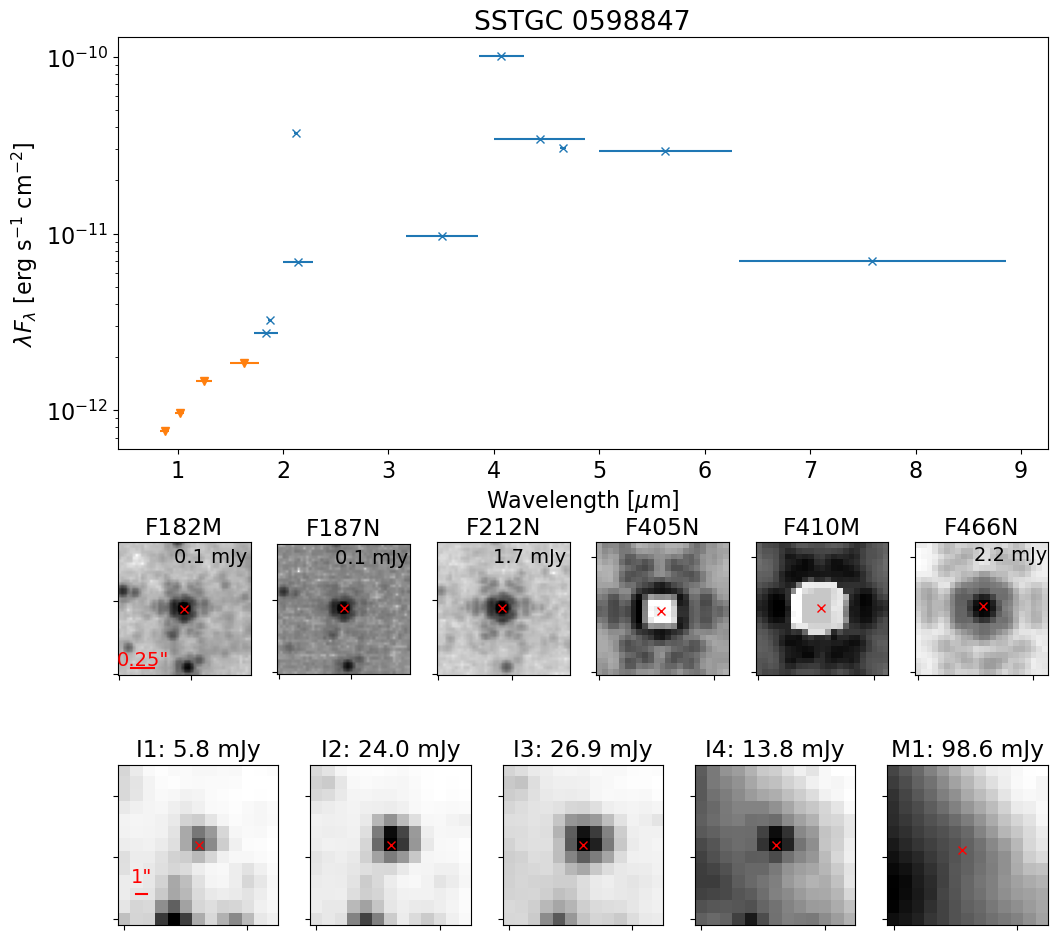

In [1189]:
triplot(0)

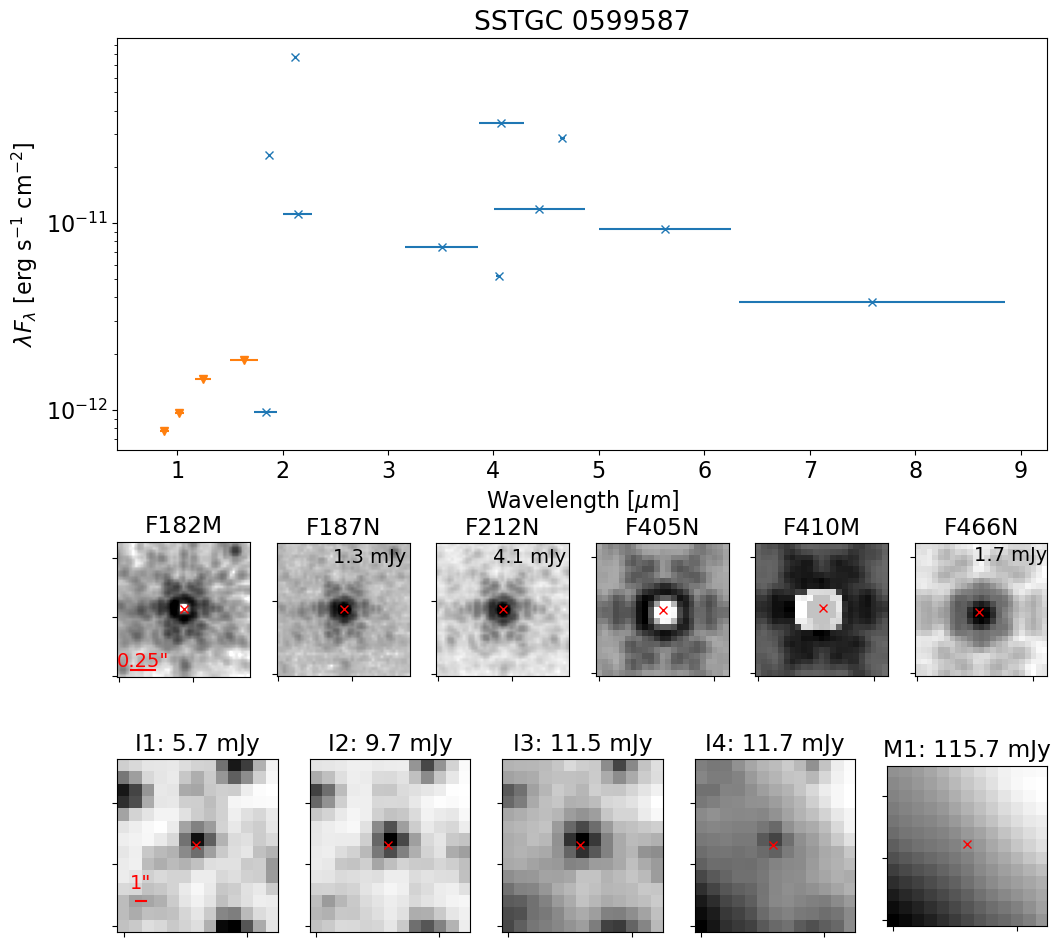

In [1190]:
triplot(1)

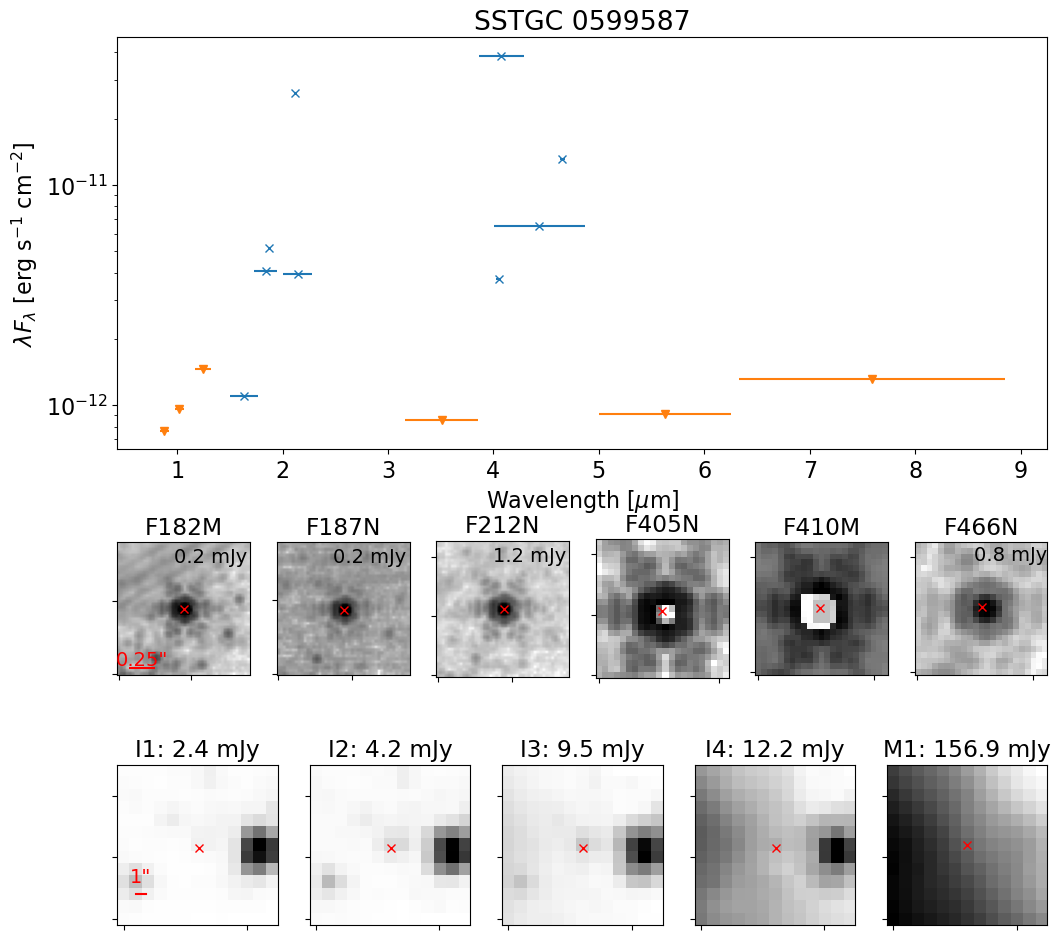

In [1191]:
triplot(2)

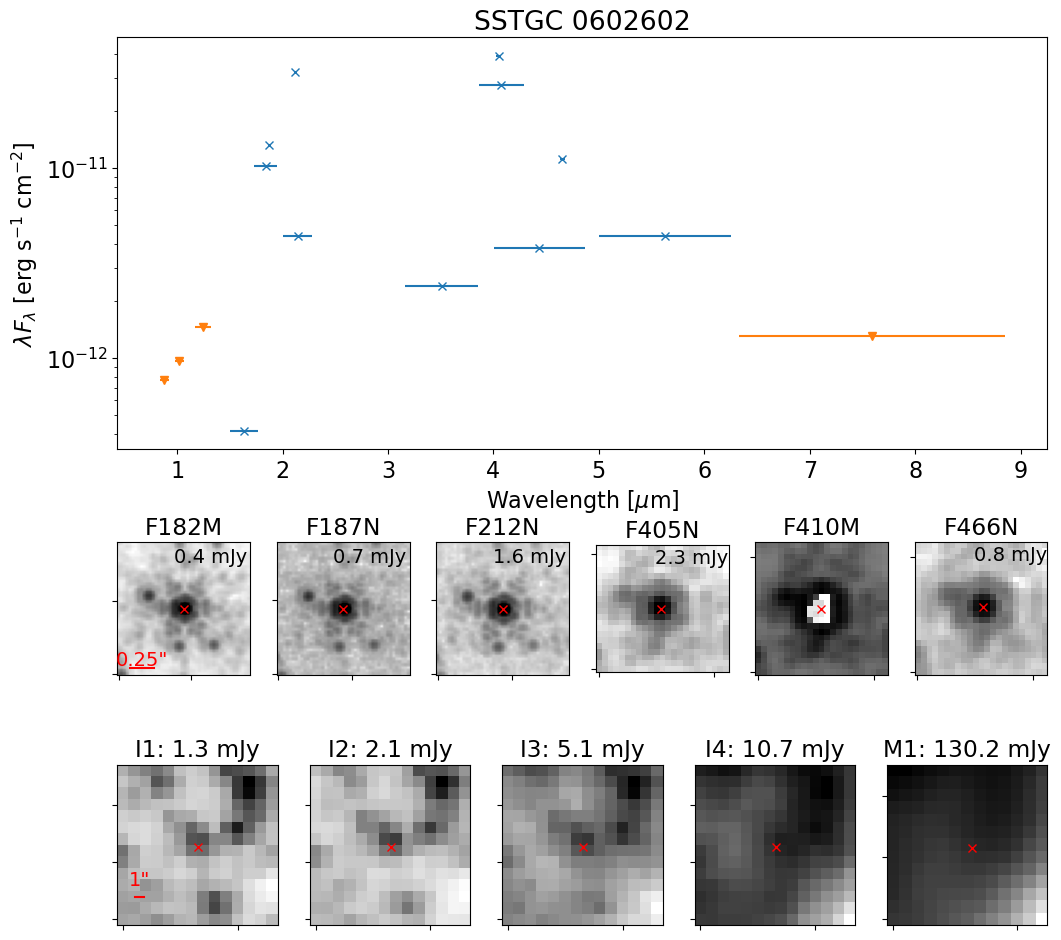

In [1192]:
triplot(3)

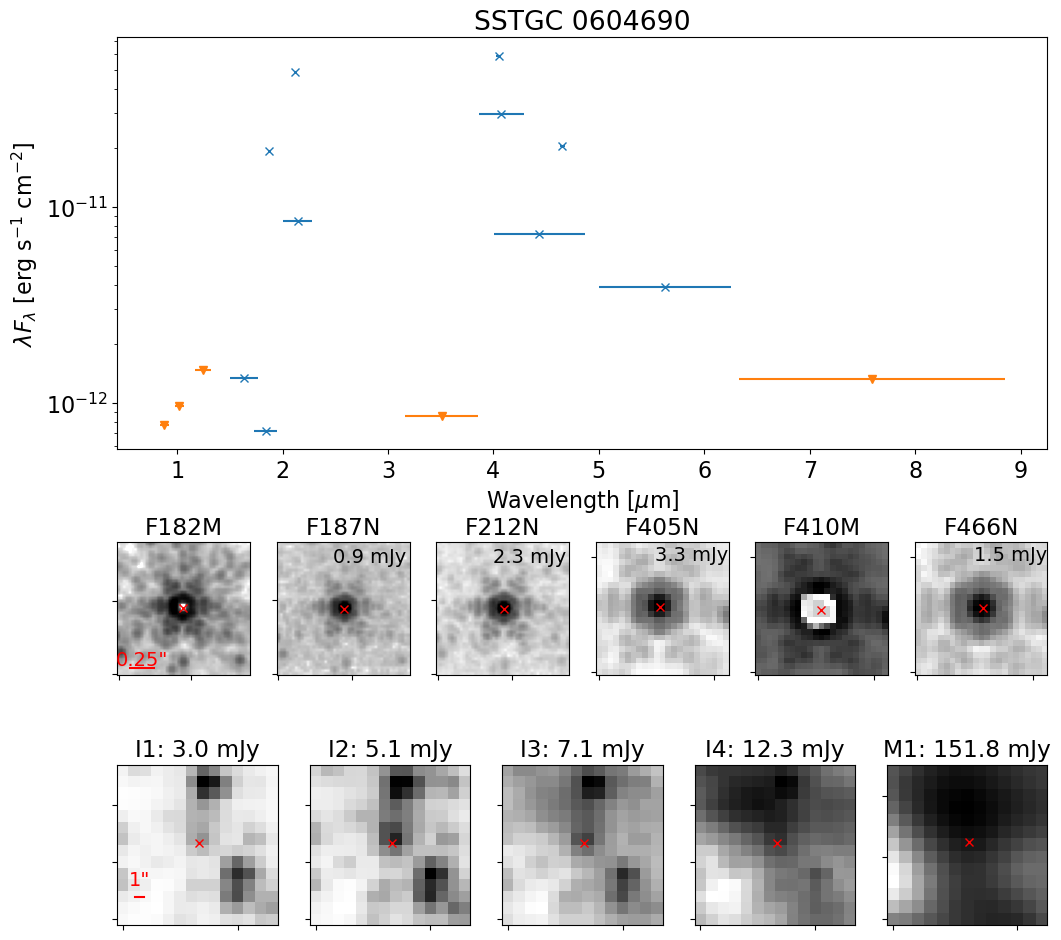

In [1193]:
triplot(4)

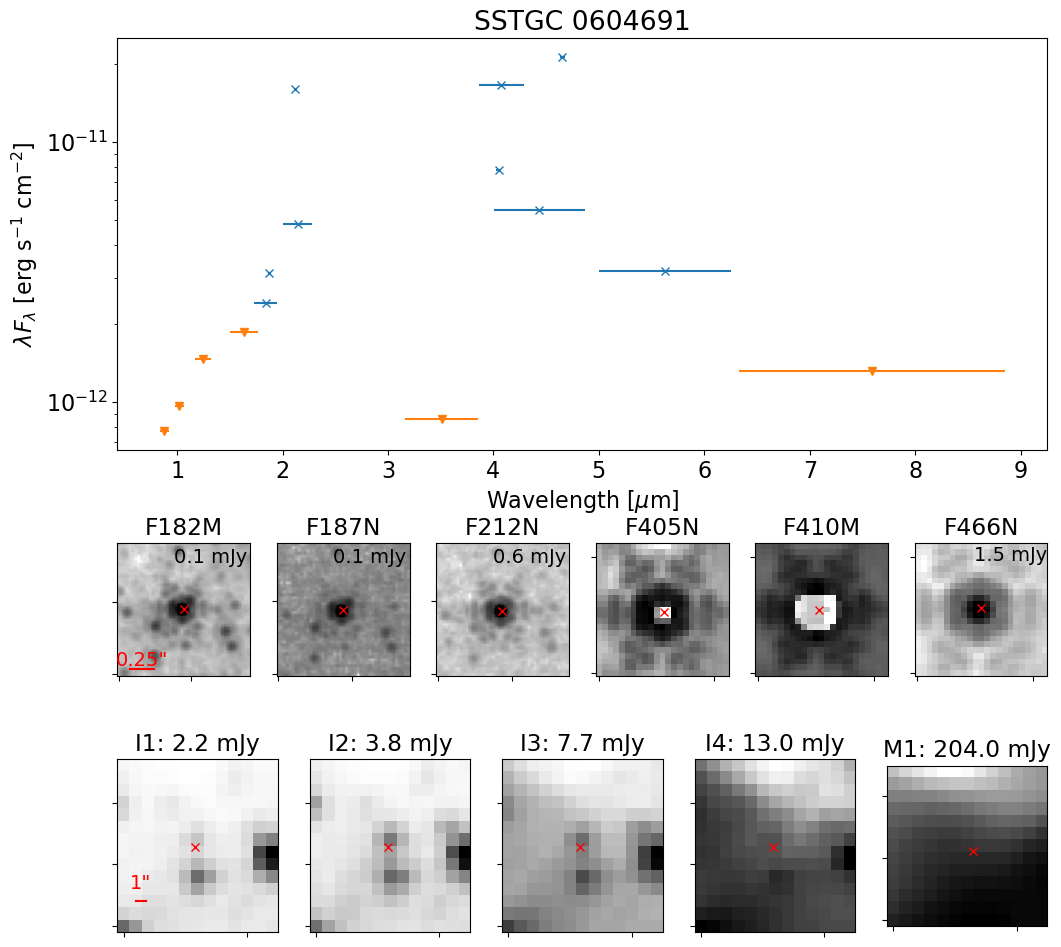

In [1194]:
triplot(5)

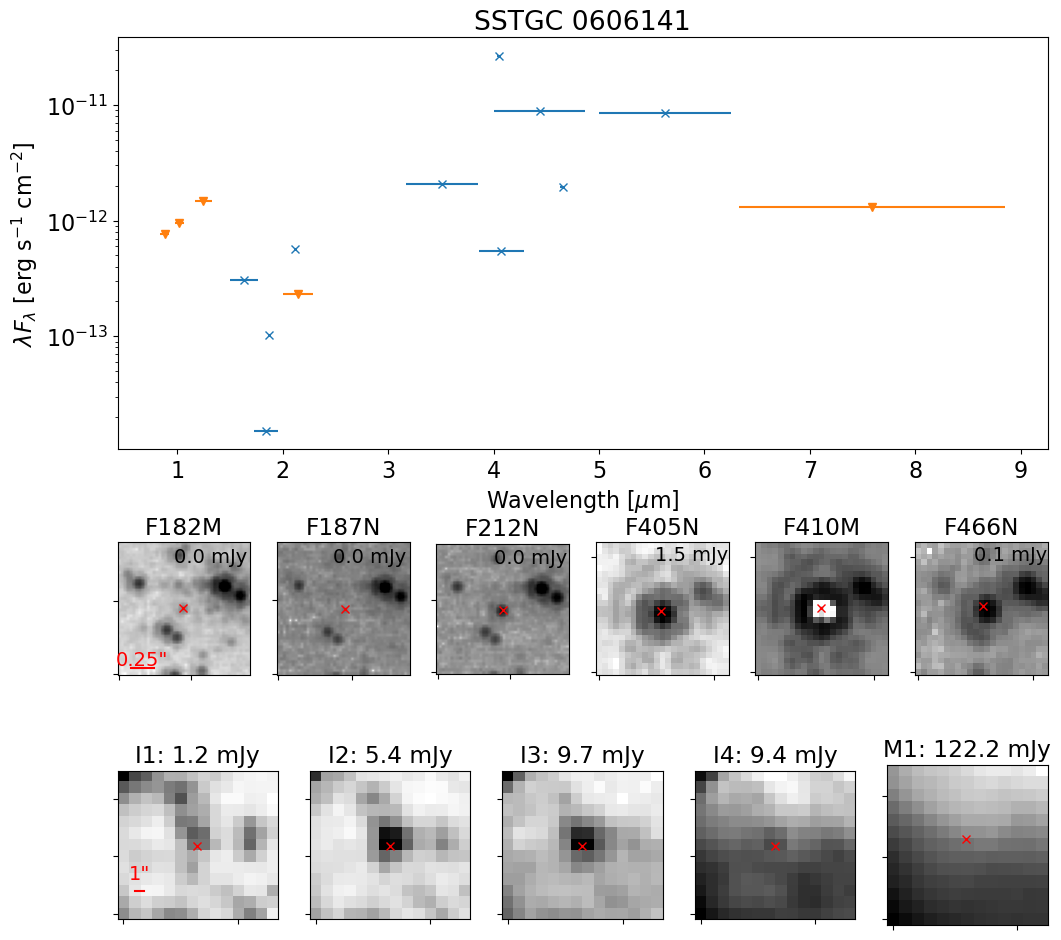

In [1195]:
triplot(6)

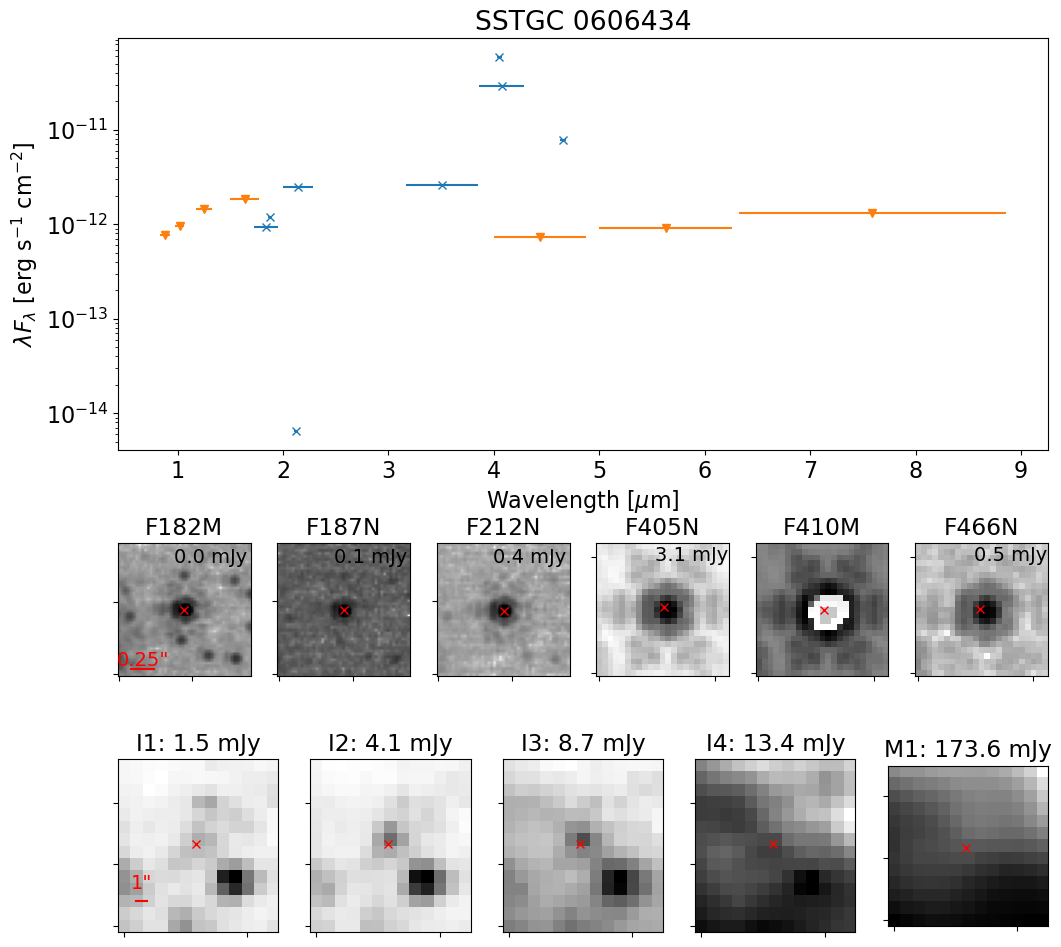

In [1196]:
triplot(7)

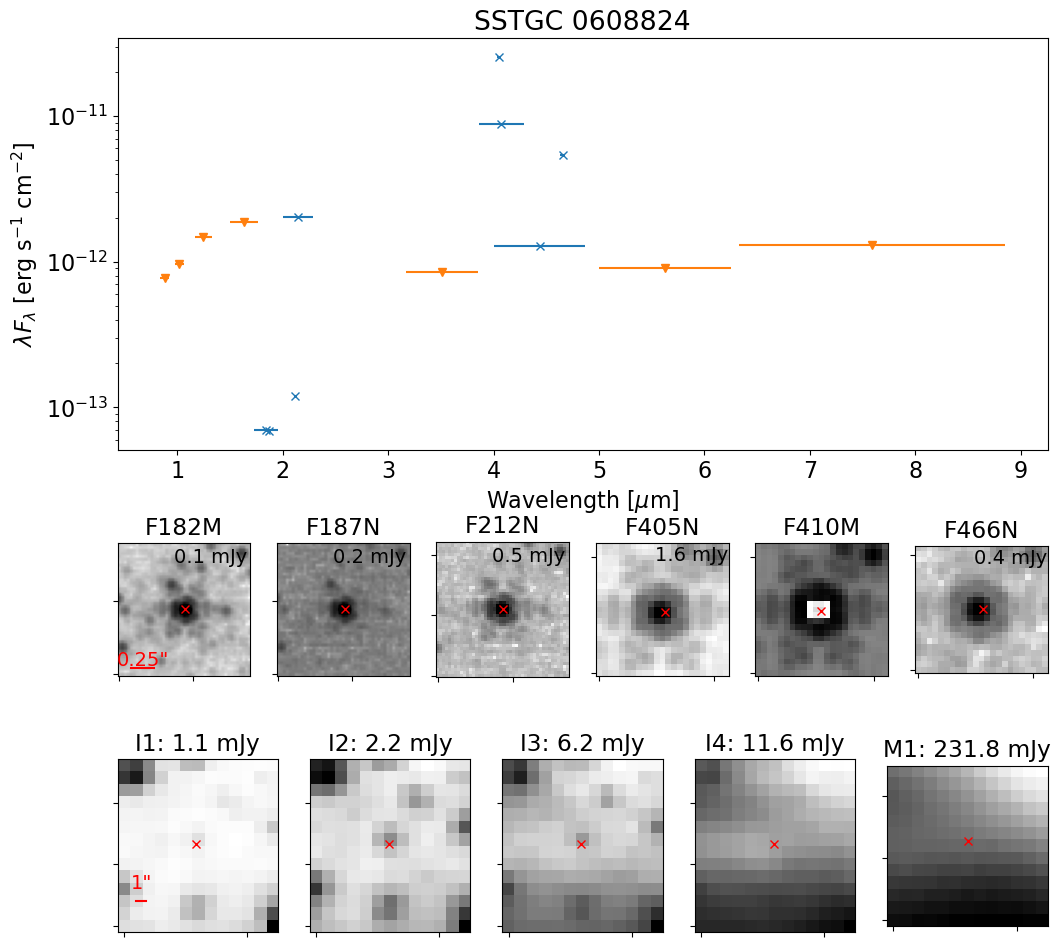

In [1197]:
triplot(8)

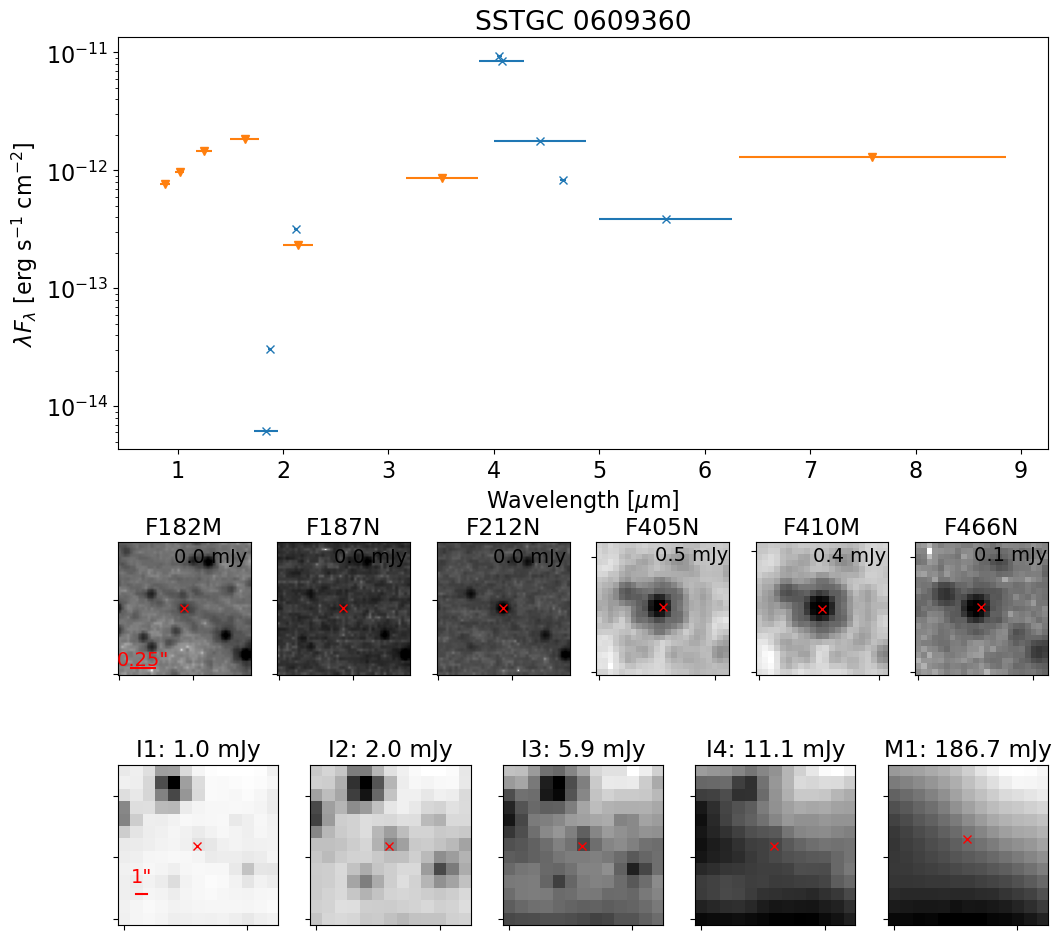

In [1198]:
triplot(9)

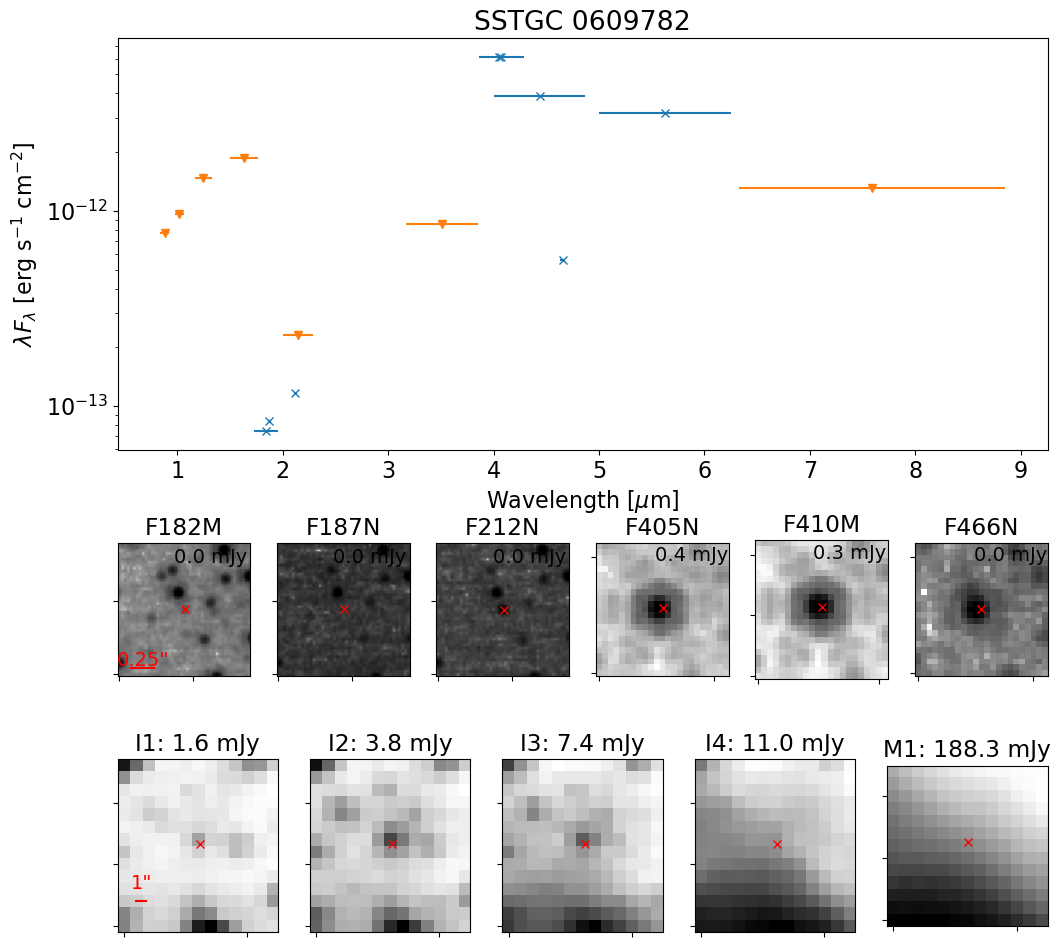

In [1199]:
triplot(10)

The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()


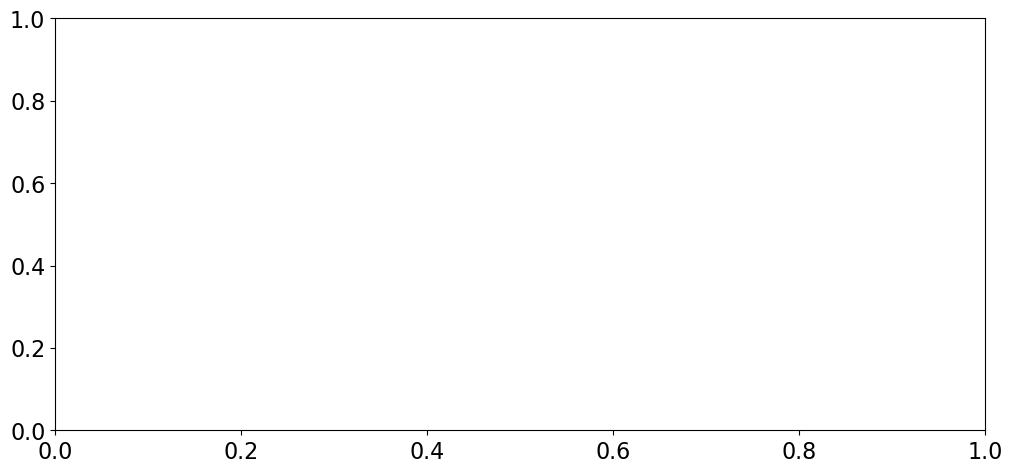

In [1200]:
triplot(11)

list index out of range


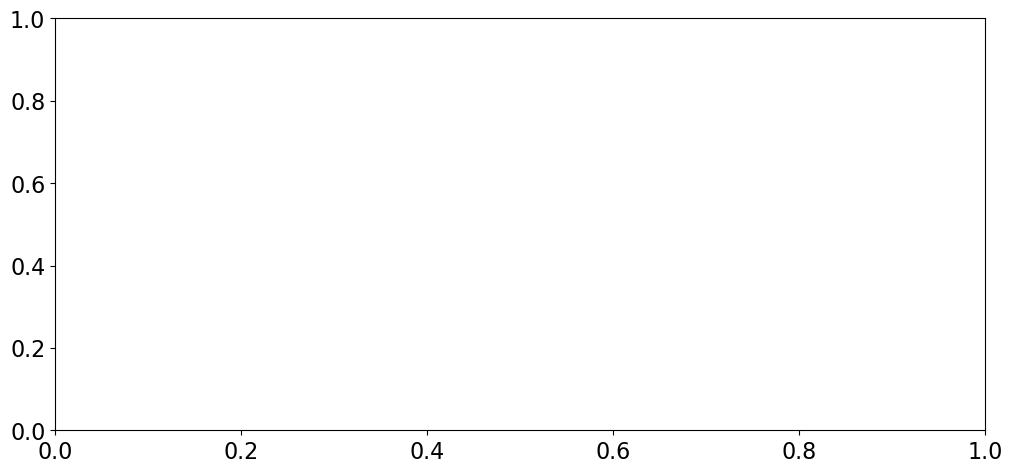

In [1201]:
triplot(12)

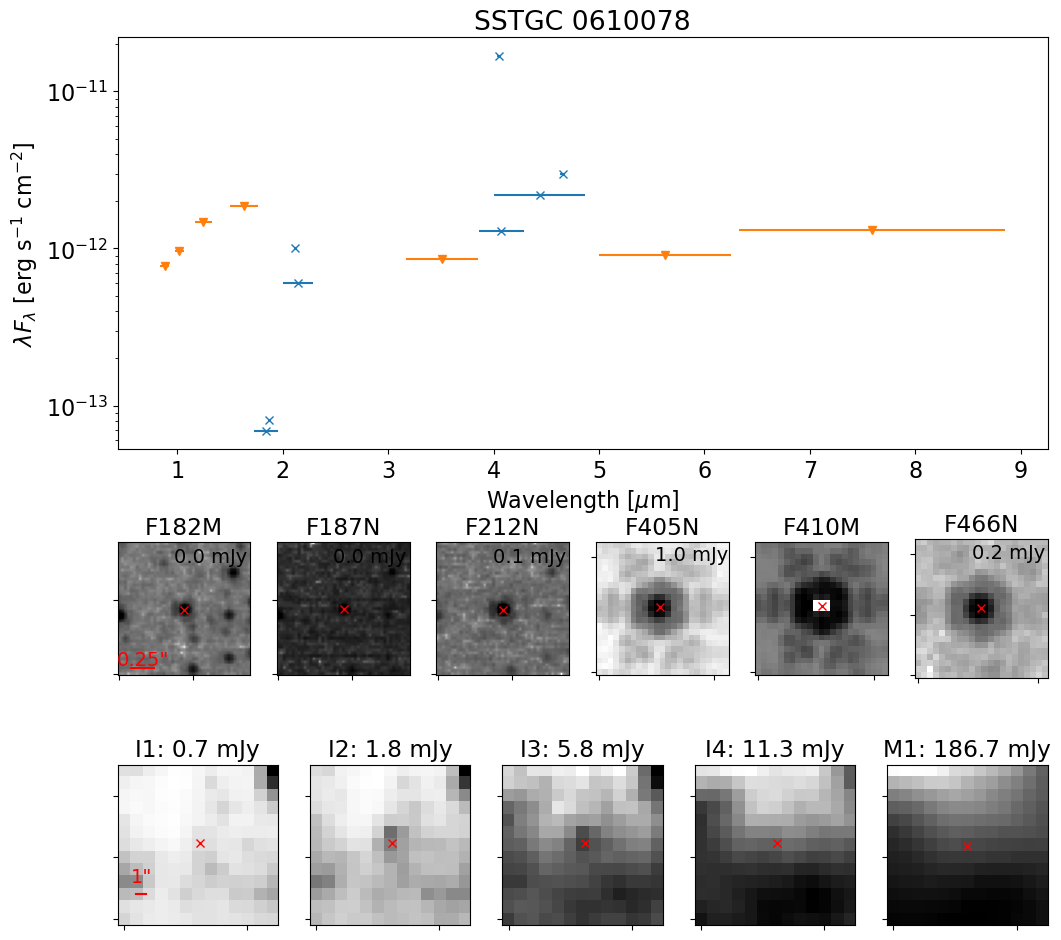

In [1202]:
triplot(13)

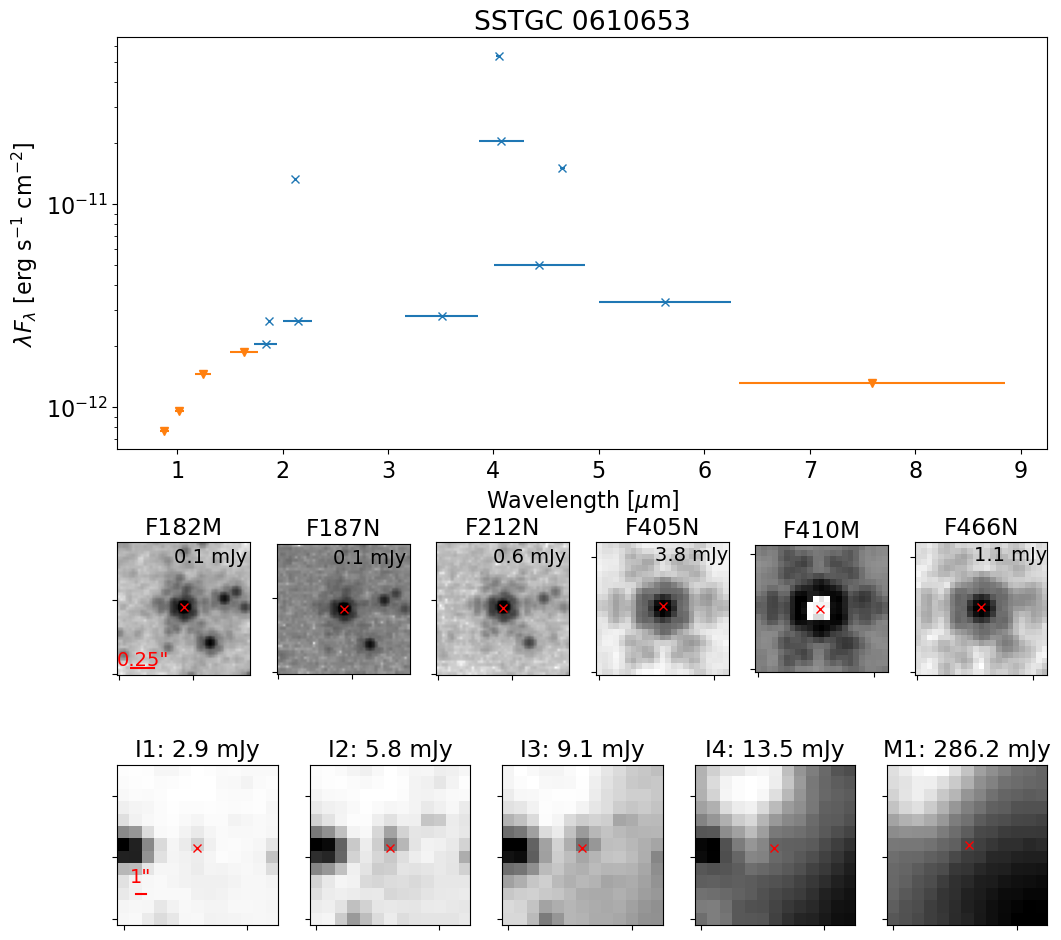

In [1203]:
triplot(14)

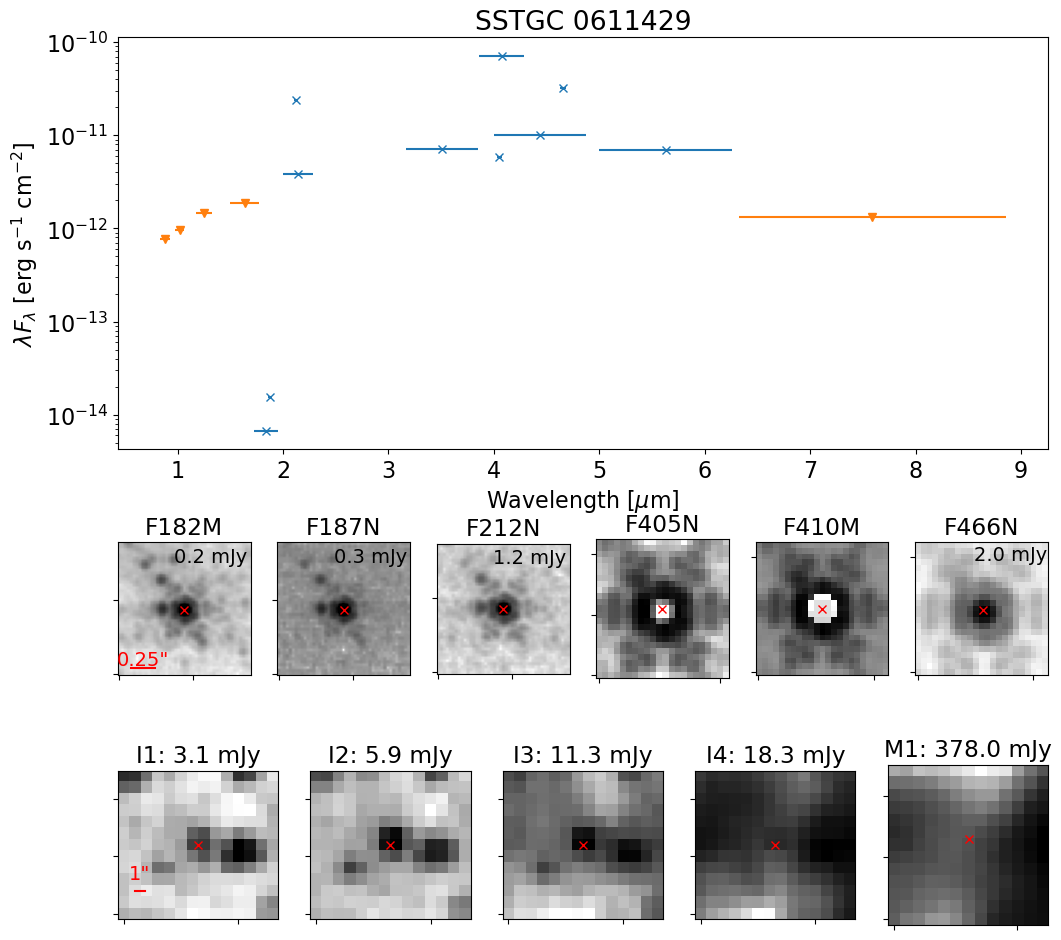

In [1204]:
triplot(15)

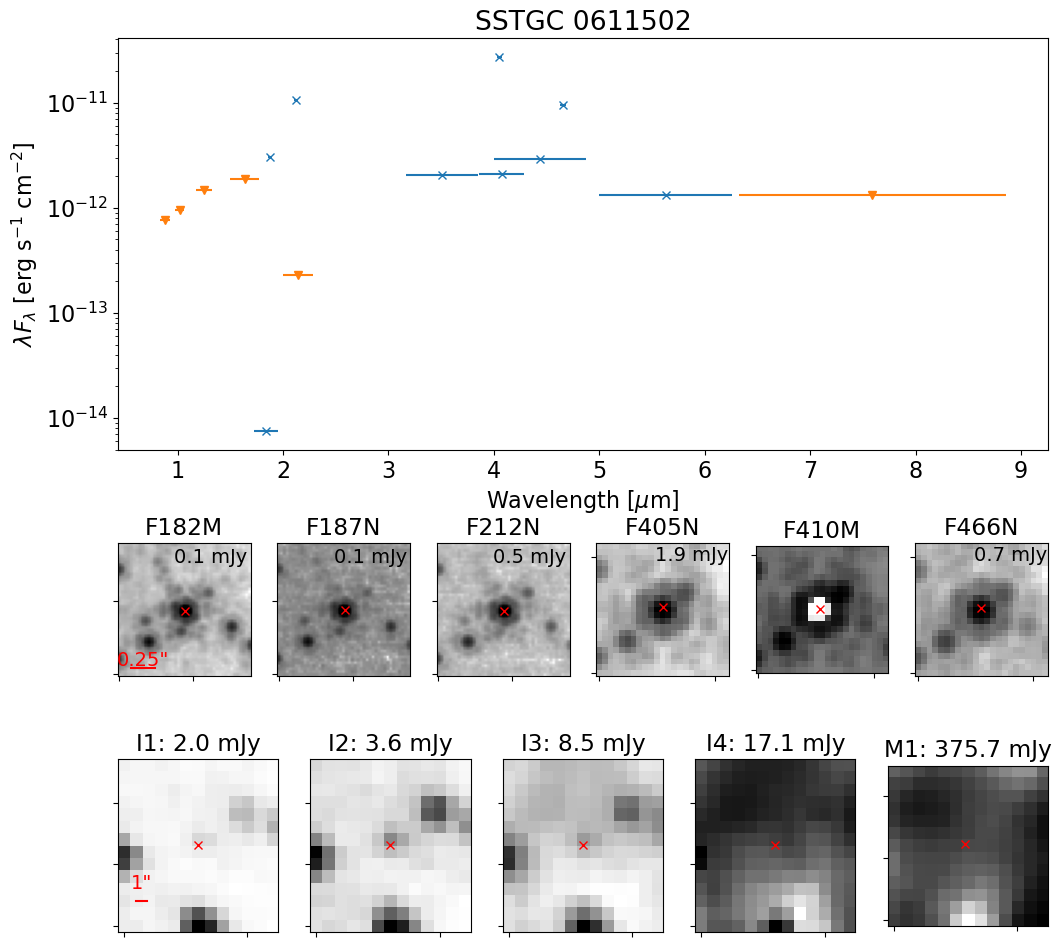

In [1205]:
triplot(16)

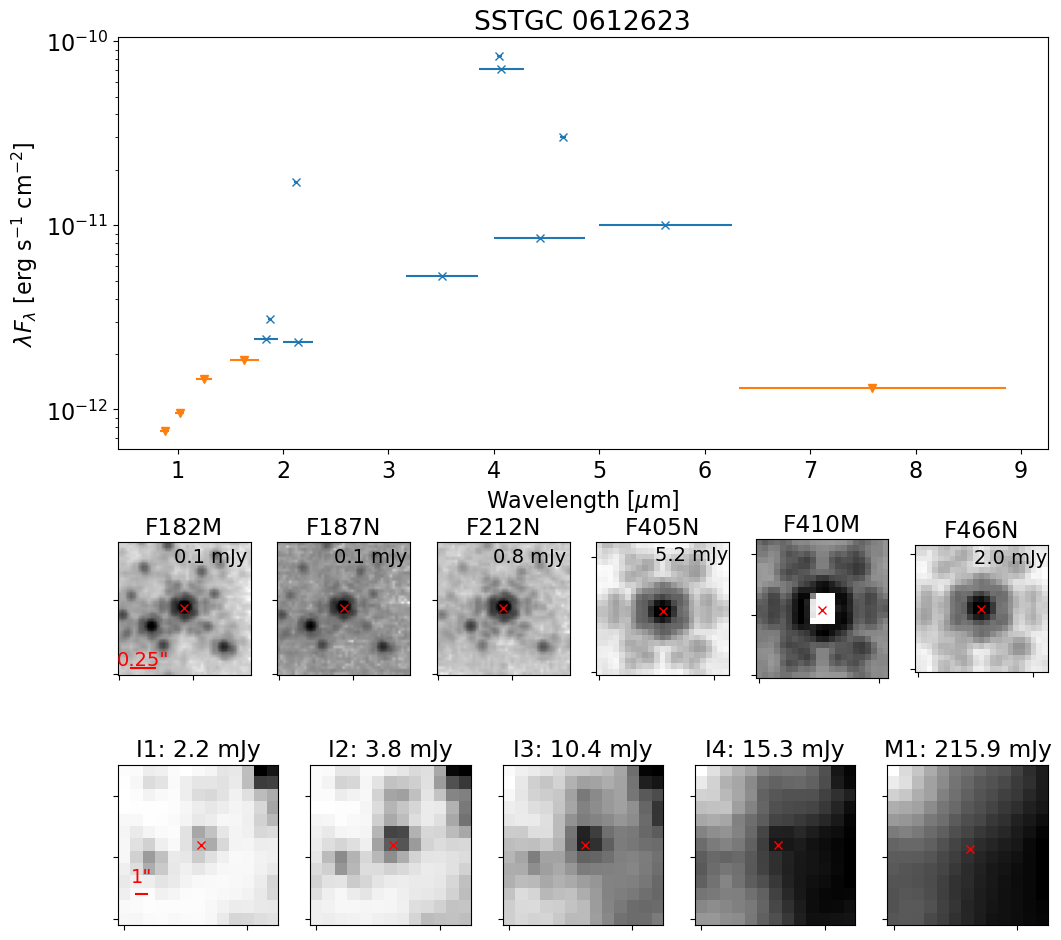

In [1206]:
triplot(17)

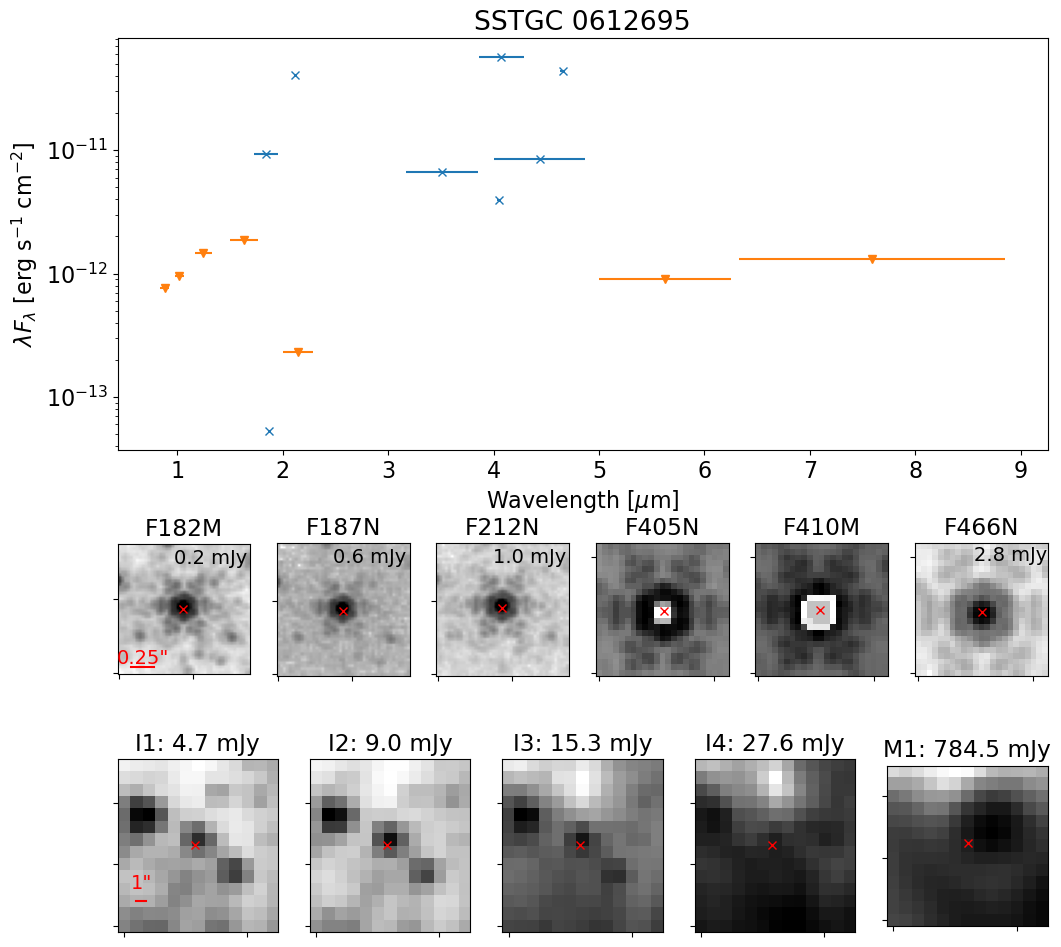

In [1207]:
triplot(18)

list index out of range


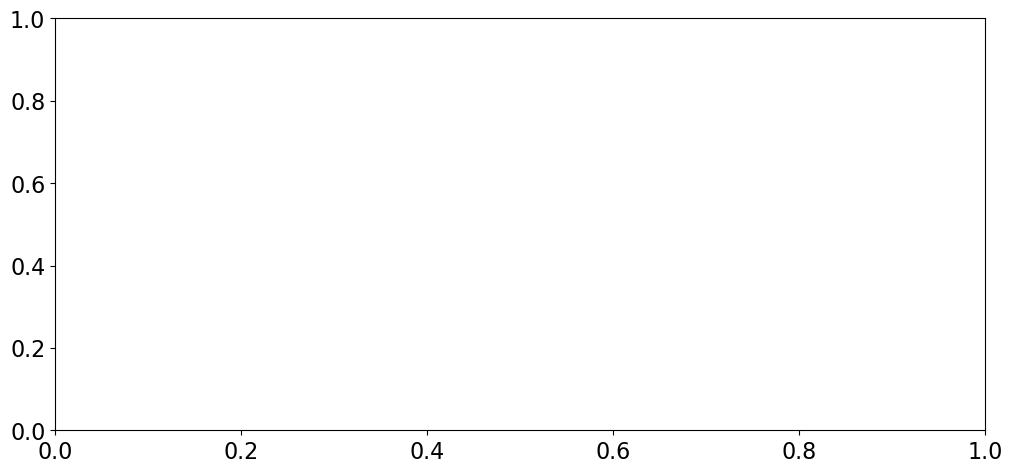

In [1208]:
triplot(19)

list index out of range


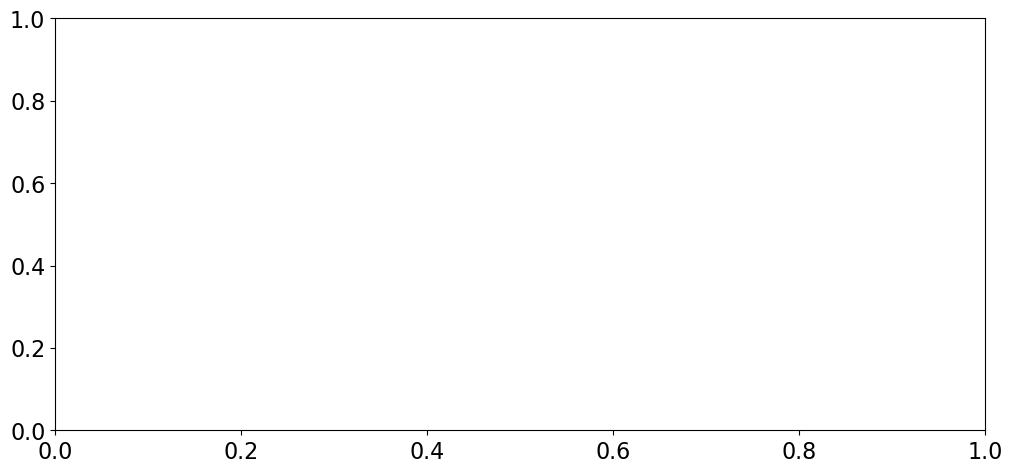

In [1209]:
triplot(20)

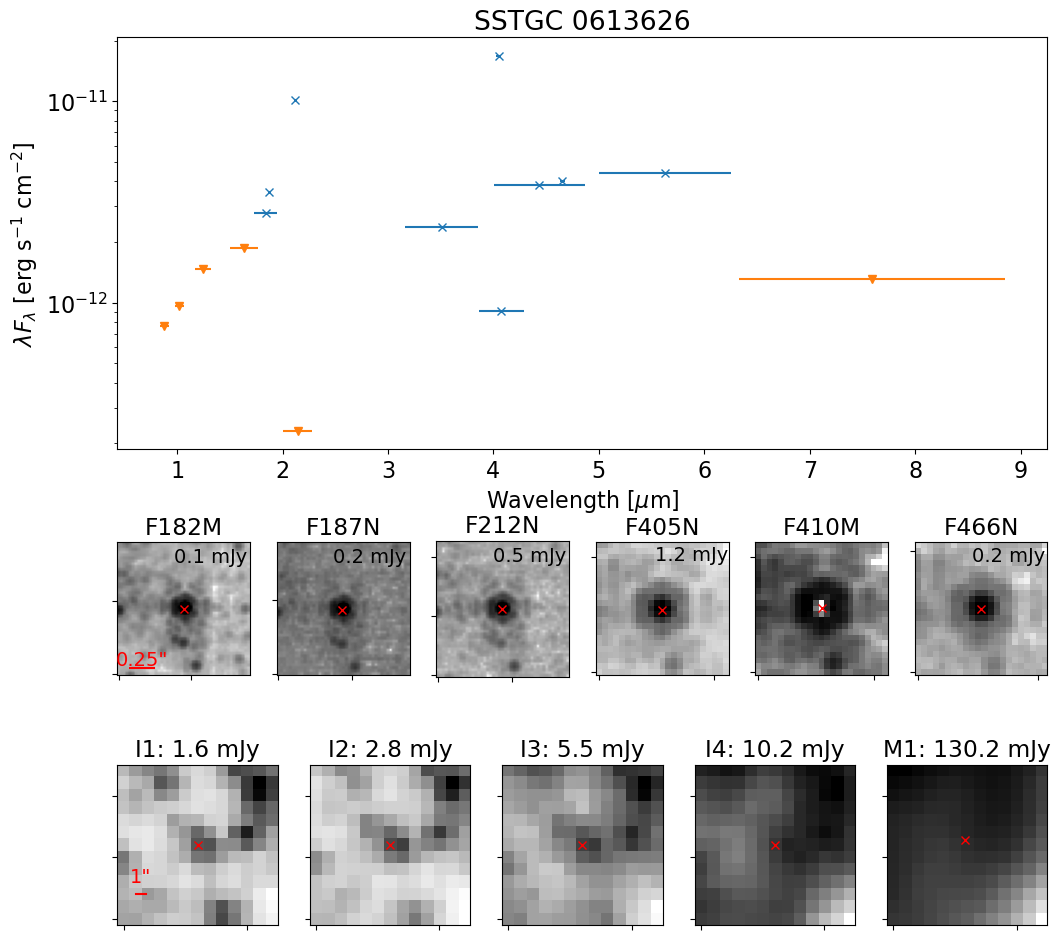

In [1210]:
triplot(21)

list index out of range


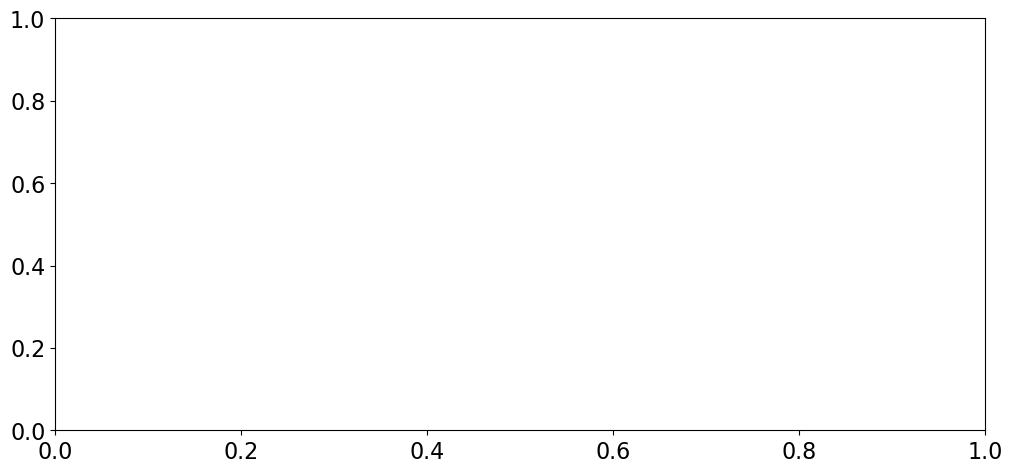

In [1211]:
triplot(22)

list index out of range


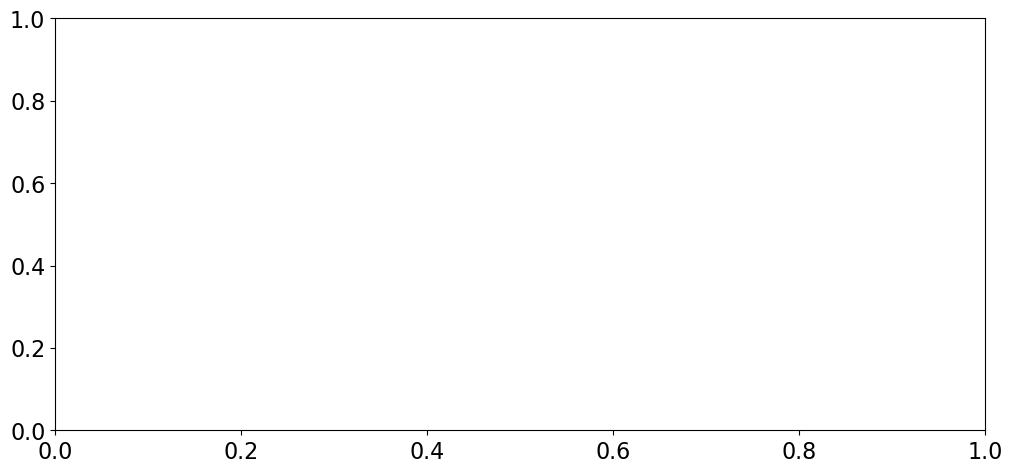

In [1212]:
triplot(23)

Set DATE-AVG to '2022-08-28T03:05:32.473' from MJD-AVG.
Set DATE-END to '2022-08-28T03:34:03.557' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -20.651775 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526292809.682 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


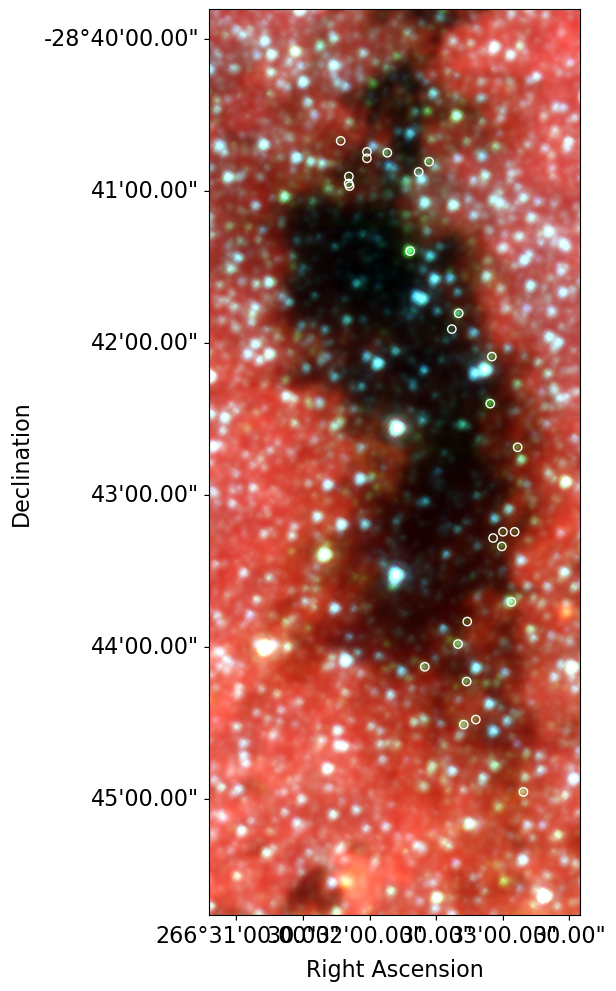

In [1127]:
avm = pyavm.AVM.from_image(f'{basepath}/images/BrickSpitzer_RGB_I421.png')
img_spitzer = np.array(PIL.Image.open(f'{basepath}/images/BrickSpitzer_RGB_I421.png'))[::-1,:,:]
wwi_spitzer_unflip = wcs.WCS(fits.Header.fromstring(avm.Spatial.FITSheader))

img_spitzer = img_spitzer.swapaxes(0,1)
wwi_spitzer = wwi_spitzer_unflip.sub([2,1])

fig = pl.figure(figsize=(12,12))
ax = pl.subplot(projection=wwi_spitzer)
ax.imshow(img_spitzer)
axlims = ax.axis()

xx,yy = wwi_spitzer.world_to_pixel(greenstarregcenters)
ax.scatter(
    xx,yy,
    #spitzer_crds.ra[spitzer['_4.5mag'] - spitzer['_8.0mag'] < 0],
    #spitzer_crds.dec[spitzer['_4.5mag'] - spitzer['_8.0mag'] < 0],
    #transform=ax.get_transform('fk5'),
    marker='o', edgecolors='w', facecolors='none',
    #markeredgewidth=0.5,
    # for non-x facecolors='none'
    #edgecolors=(0.3, 0.5, 0.8), a 
);

#ax.scatter(crds.ra[blue_410_405], crds.dec[blue_410_405], edgecolors='orange', facecolors='none', transform=ax.get_transform('world'))
ax.coords['ra'].set_axislabel('Right Ascension')
ax.coords['dec'].set_axislabel('Declination')

ra = lon = ax.coords['ra']
dec = lat = ax.coords['dec']
lon.set_major_formatter('dd:mm:ss.ss')
lat.set_major_formatter('dd:mm:ss.ss')
#lon.set_ticks(spacing=30. * u.arcsec, color='red')
#lat.set_ticks(spacing=30. * u.arcsec, color='blue')
#lon.set_ticklabel(color='red')
#lat.set_ticklabel(color='blue')
#lon.grid(color='red')
#lat.grid(color='blue')

ax.axis(axlims)

dec.set_ticks_position('l')
dec.set_ticklabel_position('l')
dec.set_axislabel_position('l')
ra.set_ticks_position('b')
ra.set_ticklabel_position('b')
ra.set_axislabel_position('b')
#fig.savefig(f"{basepath}/images/BlueStarsWithSpitzerMatches_on_RGB.png", bbox_inches='tight')

In [1128]:
spitzer[:1]

<Table length=1>
 SSTGC    RAJ2000     DEJ2000     Jmag    Hmag    Ksmag   _3.6mag _4.5mag _5.8mag _8.0mag IRAC _2M 
          'h:m:s'     'd:m:s'     mag     mag      mag      mag     mag     mag     mag            
  str7     str11       str11    float32 float32  float32  float32 float32 float32 float32 str4 str2
------- ----------- ----------- ------- -------- -------- ------- ------- ------- ------- ---- ----
0604691 17 46 08.93 -28 41 22.5  15.819   14.663   12.374  10.953   8.864   8.285   8.895 IRAC   2M

In [1129]:
basetable[:2]

<Table length=2>
     x_f410m            y_f410m       flux_f410m passno_f410m dx_f410m dy_f410m  dflux_f410m  qf_f410m rchi2_f410m fracflux_f410m ... replaced_saturated_f182m flux_jy_410m405 mag_ab_410m405 flux_jy_405m410 mag_ab_405m410 flux_jy_182m187 mag_ab_182m187 flux_jy_187m182 mag_ab_187m182
                                                                                                                                  ...                                 Jy                             Jy                             Jy                             Jy                     
     float64            float64        float32     float64    float32  float32     float32    float32    float32      float32     ...           bool               float32        float32         float32        float32         float32        float32         float32        float32    
------------------ ------------------ ---------- ------------ -------- -------- ------------- -------- ----------- -------------- ... ------------------------ --------------- -------------- --------------- -------------- --------------- -------------- --------------- --------------
22.910555958747864  1.388098955154419  1017540.1          0.0    1e+20    1e+20 10000000000.0      0.0         0.0            0.0 ...                    False       0.8718623       9.048881      0.26862264      10.327144   2.6814087e-05      20.329092   3.5002602e-05       20.03975
29.032370388507843 0.3901378810405731   441800.9          0.0    1e+20    1e+20 10000000000.0      0.0         0.0            0.0 ...                    False      0.54520017        9.55861      -1.0917821             --   1.2867784e-05      21.126242    8.170347e-05      19.119398

In [1130]:
SvoFps.get_filter_list(facility="JWST", instrument="NIRCAM")[:1]

<Table length=1>
FilterProfileService      filterID     WavelengthUnit WavelengthUCD PhotSystem DetectorType  Band  Instrument Facility ...       PhotCalID        MagSys    ZeroPoint    ZeroPointUnit   Mag0  ZeroPointType AsinhSoft                            TrasmissionCurve                          
                                                                                                                       ...                                      Jy                                                                                                                          
       object              object          object         object      object      object    object   object    object  ...         object         object     float64         object    float64     object     float64                                  object                               
-------------------- ----------------- -------------- ------------- ---------- ------------ ------ ---------- -------- ... ---------------------- ------ --------------- ------------- ------- ------------- --------- ---------------------------------------------------------------------
       ivo://svo/fps JWST/NIRCam.F070W       Angstrom         em.wl     NIRCam            1            NIRCam     JWST ... JWST/NIRCam.F070W/Vega   Vega 2768.4045696982            Jy     0.0        Pogson       0.0 http://svo2.cab.inta-csic.es//theory/fps/fps.php?ID=JWST/NIRCam.F070W

# not (yet) used

In [1131]:
vvvdr2 = Vizier.query_region(coordinates=coord, width=width, height=height, catalog=['II/348/vvv2'])[0]
vvvdr2_crds = SkyCoord(vvvdr2['RAJ2000'], vvvdr2['DEJ2000'], frame='fk5')
idx, sidx, sep, sep3d = vvvdr2_crds.search_around_sky(skycrds_cat, 0.2*u.arcsec)

twomass_crds = SkyCoord(twomass['RAJ2000'], twomass['DEJ2000'], frame='fk5')

In [1132]:
spitzer[:10]

<Table length=1>
 SSTGC    RAJ2000     DEJ2000     Jmag    Hmag    Ksmag   _3.6mag _4.5mag _5.8mag _8.0mag IRAC _2M 
          'h:m:s'     'd:m:s'     mag     mag      mag      mag     mag     mag     mag            
  str7     str11       str11    float32 float32  float32  float32 float32 float32 float32 str4 str2
------- ----------- ----------- ------- -------- -------- ------- ------- ------- ------- ---- ----
0604691 17 46 08.93 -28 41 22.5  15.819   14.663   12.374  10.953   8.864   8.285   8.895 IRAC   2M

# An2011 Vizier

In [1133]:
an2011 = Vizier(row_limit=500).get_catalogs(['J/ApJ/736/133/table1'])[0]

In [1134]:
an2011crds = SkyCoord(an2011['RAJ2000'], an2011['DEJ2000'], frame='fk5', unit=(u.h, u.deg))

In [1135]:
an2011[wwi_spitzer.footprint_contains(an2011crds)]

<Table length=3>
SSTGC   Y     RAJ2000     DEJ2000      Date      Us  F02  S06  Y09  f_Y09 YSOcat
              'h:m:s'     'd:m:s'    'Y:M:D'                                    
int32  str1    str11       str11      str10     str5 str3 str3 str3  str1 int16 
------ ---- ----------- ----------- ---------- ----- ---- ---- ---- ----- ------
600274      17 46 07.39 -28 45 32.0 2008-05-01    no                           0
618018    Y 17 46 13.81 -28 43 44.5 2008-05-01 maybe  yes                      1
619522    Y 17 46 14.33 -28 43 18.4 2008-05-01 maybe                           0

Set DATE-AVG to '2022-08-28T03:05:32.473' from MJD-AVG.
Set DATE-END to '2022-08-28T03:34:03.557' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -20.651775 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526292809.682 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


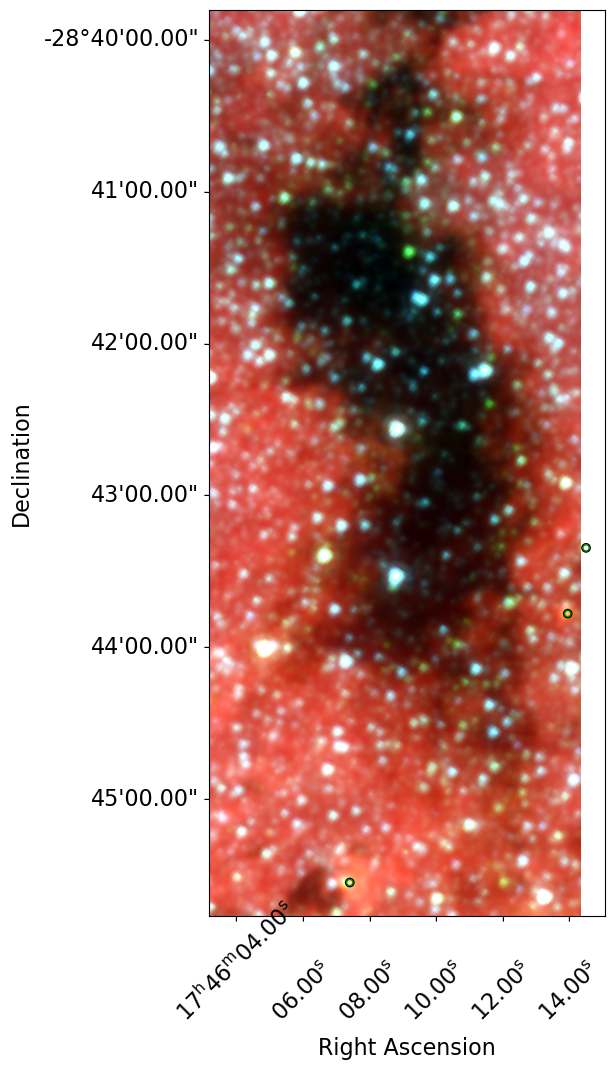

In [1136]:
# This image shows only H-alpha stars
avm = pyavm.AVM.from_image(f'{basepath}/images/BrickSpitzer_RGB_I421.png')
img_spitzer = np.array(PIL.Image.open(f'{basepath}/images/BrickSpitzer_RGB_I421.png'))[::-1,:,:]
#wwi_bra_410 = avm.to_wcs(use_full_header=True)
wwi_spitzer = wcs.WCS(fits.Header.fromstring(avm.Spatial.FITSheader))

img_spitzer = img_spitzer.swapaxes(0,1)
wwi_spitzer = wwi_spitzer.sub([2,1])

fig = pl.figure(figsize=(12,12))
ax = pl.subplot(projection=wwi_spitzer)
ax.imshow(img_spitzer)
axlims = ax.axis()

xx,yy = wwi_spitzer.world_to_pixel(an2011crds[wwi_spitzer.footprint_contains(an2011crds)])
ax.scatter(
    xx,yy,
    #spitzer_crds.ra[spitzer['_4.5mag'] - spitzer['_8.0mag'] < 0],
    #spitzer_crds.dec[spitzer['_4.5mag'] - spitzer['_8.0mag'] < 0],
    #transform=ax.get_transform('fk5'),
    marker='o', edgecolors='black', facecolors='none',
    #markeredgewidth=0.5,
    # for non-x facecolors='none'
    #edgecolors=(0.3, 0.5, 0.8), a 
);
ax.scatter(
    xx,yy,
    s=20,
    marker='o', edgecolors='g', facecolors='none',
);
#ax.scatter(crds.ra[blue_410_405], crds.dec[blue_410_405], edgecolors='orange', facecolors='none', transform=ax.get_transform('world'))
ax.coords['ra'].set_axislabel('Right Ascension')
ax.coords['dec'].set_axislabel('Declination')

ra = lon = ax.coords['ra']
dec = lat = ax.coords['dec']
lon.set_major_formatter('hh:mm:ss.ss')
lat.set_major_formatter('dd:mm:ss.ss')
lon.set_ticks(spacing=30. * u.arcsec)
lon.set_ticklabel(rotation=45, pad=60)
#lat.set_ticks(spacing=30. * u.arcsec, color='blue')



#ax.axis(axlims)

dec.set_ticks_position('l')
dec.set_ticklabel_position('l')
dec.set_axislabel_position('l')
ra.set_ticks_position('b')
ra.set_ticklabel_position('b')
ra.set_axislabel_position('b')
#fig.savefig(f"{basepath}/images/BlueStarsWithSpitzerMatches_on_RGB.png", bbox_inches='tight')

# make CCDs/CMDs highlighting the green stars

also show the stars with nondetections in one or more bands

In [1137]:
inds_green, rev_inds, sep, sep3d = greenstarregcenters.search_around_sky(spitzer_crds, 2*u.arcsec)

(array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 array([8.395   , 8.495001, 8.595   , 8.695001, 8.795   , 8.895   ,
        8.995001, 9.095   , 9.195001, 9.295   , 9.395   ], dtype=float32),
 <BarContainer object of 10 artists>)

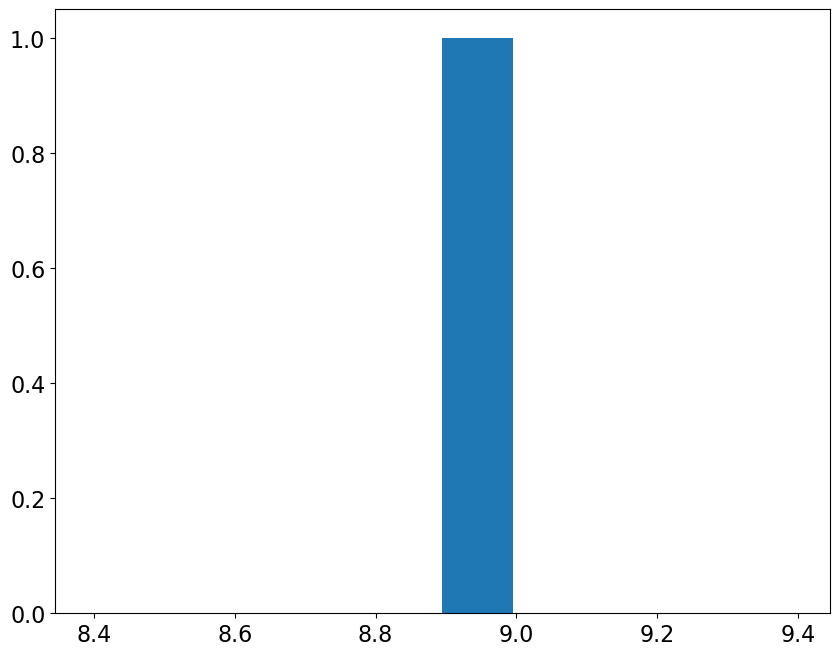

In [1138]:
pl.hist(spitzer['_8.0mag'])

In [1139]:
i4lim = np.nanpercentile(np.array(spitzer['_8.0mag']), 99)
i3lim = np.nanpercentile(np.array(spitzer['_5.8mag']), 99)
i2lim = np.nanpercentile(np.array(spitzer['_4.5mag']), 99)
i1lim = np.nanpercentile(np.array(spitzer['_3.6mag']), 99)
i1lim, i2lim, i3lim, i4lim

(10.95300006866455, 8.86400032043457, 8.28499984741211, 8.895000457763672)

In [1140]:
spitzer[inds_green]

<Table length=1>
 SSTGC    RAJ2000     DEJ2000     Jmag    Hmag    Ksmag   _3.6mag _4.5mag _5.8mag _8.0mag IRAC _2M 
          'h:m:s'     'd:m:s'     mag     mag      mag      mag     mag     mag     mag            
  str7     str11       str11    float32 float32  float32  float32 float32 float32 float32 str4 str2
------- ----------- ----------- ------- -------- -------- ------- ------- ------- ------- ---- ----
0604691 17 46 08.93 -28 41 22.5  15.819   14.663   12.374  10.953   8.864   8.285   8.895 IRAC   2M

Text(0, 0.5, 'I2-I4')

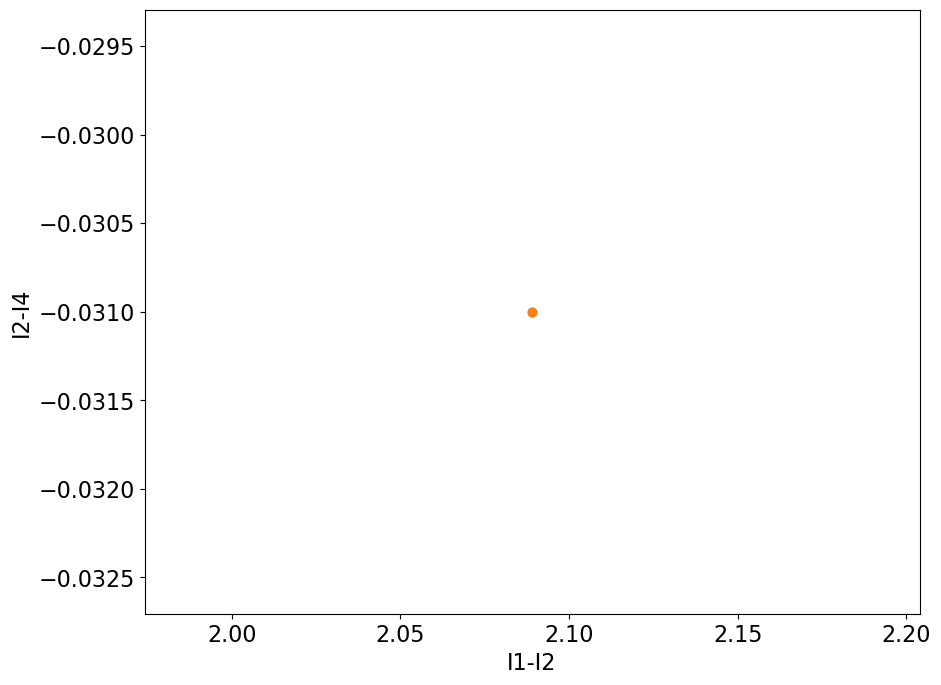

In [1141]:
pl.scatter(spitzer['_3.6mag'] - spitzer['_4.5mag'],  spitzer['_4.5mag'] - spitzer['_8.0mag'])
pl.scatter(spitzer['_3.6mag'][inds_green] - spitzer['_4.5mag'][inds_green],  spitzer['_4.5mag'][inds_green] - spitzer['_8.0mag'][inds_green])
pl.xlabel("I1-I2")
pl.ylabel("I2-I4")

From SED inspection, done below, it is common to have I3 detection but I4 nondetection

In [1142]:
green_spitzer = (np.array(spitzer['_4.5mag'] - spitzer['_8.0mag'] < 0.5) |
                 (np.array(spitzer['_4.5mag'] - spitzer['_5.8mag'] < 0.0)))
green_nored = np.array((spitzer['_4.5mag'] < i2lim-1) & (spitzer['_8.0mag'].mask))
redI1I2 = ((np.array(spitzer['_3.6mag'] - spitzer['_4.5mag'] > 1)) |
           (np.array(spitzer['_3.6mag'].mask & ~spitzer['_4.5mag'].mask)))
reddish_i1i2_spitzer_and_greeni2i4 = (redI1I2 &
                                      (green_nored | green_spitzer)
                                      & wwi_spitzer_unflip.footprint_contains(spitzer_crds)
                                     )
reddish_i1i2_spitzer_and_greeni2i4.sum()

1

Set DATE-AVG to '2022-08-28T03:05:32.473' from MJD-AVG.
Set DATE-END to '2022-08-28T03:34:03.557' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -20.651775 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526292809.682 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


These #'s should be equal: 1 1


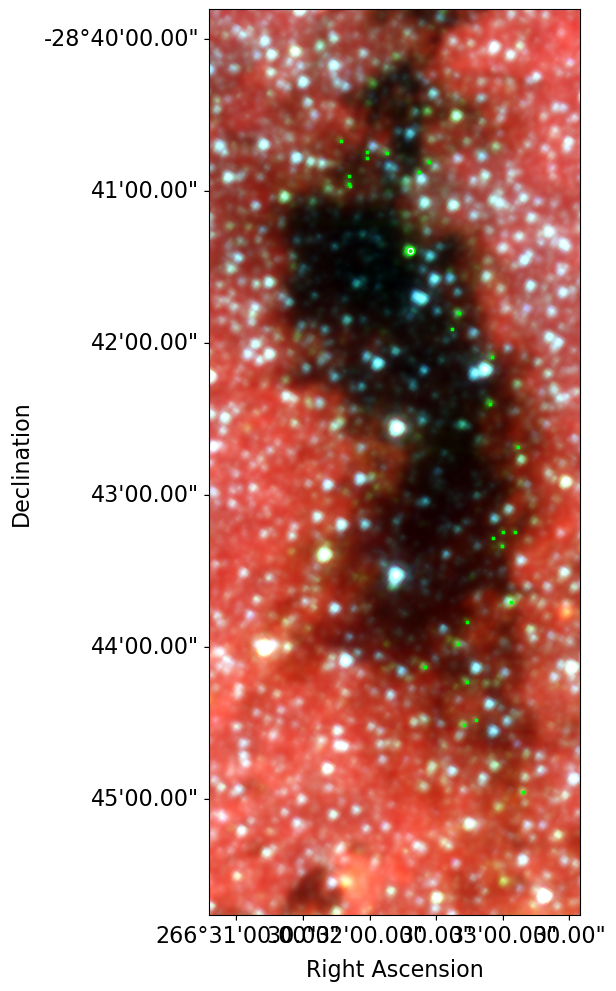

In [1143]:
avm = pyavm.AVM.from_image(f'{basepath}/images/BrickSpitzer_RGB_I421.png')
img_spitzer = np.array(PIL.Image.open(f'{basepath}/images/BrickSpitzer_RGB_I421.png'))[::-1,:,:]
#wwi_bra_410 = avm.to_wcs(use_full_header=True)
wwi_spitzer_unflip = wcs.WCS(fits.Header.fromstring(avm.Spatial.FITSheader))

img_spitzer = img_spitzer.swapaxes(0,1)
wwi_spitzer = wwi_spitzer_unflip.sub([2,1])

fig = pl.figure(figsize=(12,12))
ax = pl.subplot(projection=wwi_spitzer)
ax.imshow(img_spitzer)
axlims = ax.axis()

green_spitzer = np.array(spitzer['_4.5mag'] - spitzer['_8.0mag'] < 0.)
green_nored = np.array((spitzer['_4.5mag'] < 10) & (spitzer['_8.0mag'].mask))
xx,yy = wwi_spitzer.world_to_pixel(spitzer_crds[reddish_i1i2_spitzer_and_greeni2i4])
print("These #'s should be equal:", reddish_i1i2_spitzer_and_greeni2i4.sum(), len(xx))
ax.scatter(
    xx,yy,
    #spitzer_crds.ra[spitzer['_4.5mag'] - spitzer['_8.0mag'] < 0],
    #spitzer_crds.dec[spitzer['_4.5mag'] - spitzer['_8.0mag'] < 0],
    #transform=ax.get_transform('fk5'),
    marker='o', edgecolors='lime', facecolors='none',
    #markeredgewidth=0.5,
    # for non-x facecolors='none'
    #edgecolors=(0.3, 0.5, 0.8), a 
);
xx,yy = wwi_spitzer.world_to_pixel(greenstarregcenters)
ax.scatter(xx, yy, marker='x', s=4, color='lime')
#xx,yy = wwi_spitzer.world_to_pixel(spitzer_crds[green_nored])
#ax.scatter(
#    xx,yy,
#    marker='o', edgecolors='b', facecolors='none',
#);
redi1i2_spitzer = (spitzer['_3.6mag'] - spitzer['_4.5mag'] > 1.75)# | ((10 < spitzer['_4.5mag']) & (spitzer['_4.5mag'] < 15) & (spitzer['_8.0mag'].mask))
xx,yy = wwi_spitzer.world_to_pixel(spitzer_crds[redi1i2_spitzer])
ax.scatter(
    xx,yy,
    #spitzer_crds.ra[spitzer['_4.5mag'] - spitzer['_8.0mag'] < 0],
    #spitzer_crds.dec[spitzer['_4.5mag'] - spitzer['_8.0mag'] < 0],
    #transform=ax.get_transform('fk5'),
    marker='o', edgecolors='w', facecolors='none',
s=15,
    # for non-x facecolors='none'
    #edgecolors=(0.3, 0.5, 0.8), a 
);
#ax.scatter(crds.ra[blue_410_405], crds.dec[blue_410_405], edgecolors='orange', facecolors='none', transform=ax.get_transform('world'))
ax.coords['ra'].set_axislabel('Right Ascension')
ax.coords['dec'].set_axislabel('Declination')

ra = lon = ax.coords['ra']
dec = lat = ax.coords['dec']
lon.set_major_formatter('dd:mm:ss.ss')
lat.set_major_formatter('dd:mm:ss.ss')
#lon.set_ticks(spacing=30. * u.arcsec, color='red')
#lat.set_ticks(spacing=30. * u.arcsec, color='blue')
#lon.set_ticklabel(color='red')
#lat.set_ticklabel(color='blue')
#lon.grid(color='red')
#lat.grid(color='blue')

ax.axis(axlims)

dec.set_ticks_position('l')
dec.set_ticklabel_position('l')
dec.set_axislabel_position('l')
ra.set_ticks_position('b')
ra.set_ticklabel_position('b')
ra.set_axislabel_position('b')
#fig.savefig(f"{basepath}/images/BlueStarsWithSpitzerMatches_on_RGB.png", bbox_inches='tight')

In [1144]:
(spitzer['_3.6mag'].mask & ~spitzer['_4.5mag'].mask).sum()

0

In [1145]:
(~spitzer['_3.6mag'].mask & spitzer['_4.5mag'].mask).sum()

0

In [1146]:
mag8mask = spitzer['_8.0mag'].mask
(reddish_i1i2_spitzer_and_greeni2i4 & mag8mask).sum()

0

(9.351520338058473, 8.376480302810668)

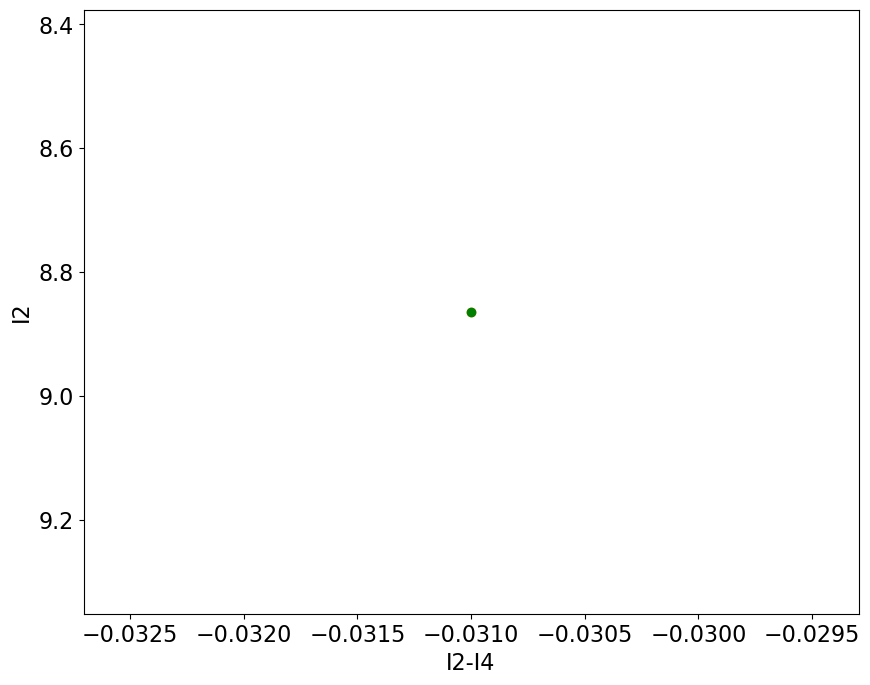

In [1147]:
i4lim = np.nanpercentile(np.array(spitzer['_8.0mag']), 99)
pl.scatter(spitzer['_4.5mag'] - spitzer['_8.0mag'],  spitzer['_4.5mag'], color='orange')
#pl.scatter(spitzer['_4.5mag'][spitzer['_8.0mag'].mask] - i4lim,  spitzer['_4.5mag'][spitzer['_8.0mag'].mask])

mag8mask = spitzer['_8.0mag'].mask
greensrcmask = np.zeros_like(mag8mask, dtype='bool')
greensrcmask[inds_green] = True
pl.scatter(spitzer['_4.5mag'][inds_green] - spitzer['_8.0mag'][inds_green], 
           spitzer['_4.5mag'][inds_green], color='g')
pl.scatter(spitzer['_4.5mag'][greensrcmask & mag8mask] - i4lim,
           spitzer['_4.5mag'][greensrcmask & mag8mask],
           marker='<',
           color='g',
          )
#pl.scatter((spitzer['_4.5mag'] - spitzer['_8.0mag'])[reddish_i1i2_spitzer_and_greeni2i4], 
#           spitzer['_4.5mag'][reddish_i1i2_spitzer_and_greeni2i4],
#          color='r')
#pl.scatter(spitzer['_4.5mag'][reddish_i1i2_spitzer_and_greeni2i4 & mag8mask] - i4lim,
#           spitzer['_4.5mag'][reddish_i1i2_spitzer_and_greeni2i4 & mag8mask],
#           marker='<',
#           color='r',
#          )


pl.xlabel("I2-I4")
pl.ylabel("I2")
pl.ylim(pl.ylim()[::-1])

(9.351520338058473, 8.376480302810668)

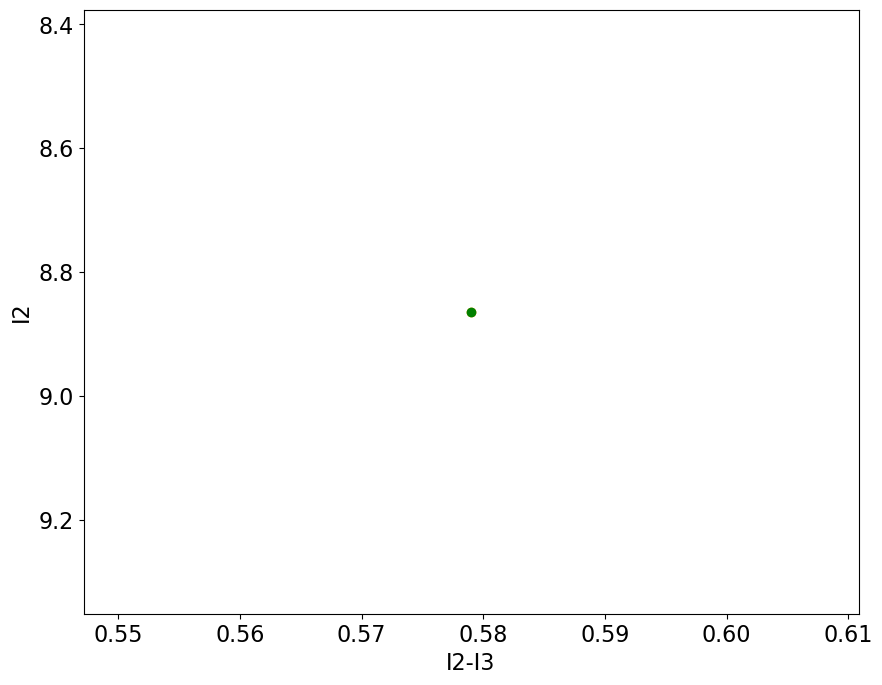

In [1148]:
pl.scatter(spitzer['_4.5mag'] - spitzer['_5.8mag'],  spitzer['_4.5mag'], color='orange')
#pl.scatter(spitzer['_4.5mag'][spitzer['_8.0mag'].mask] - i4lim,  spitzer['_4.5mag'][spitzer['_8.0mag'].mask])

magi3mask = spitzer['_5.8mag'].mask
greensrcmask = np.zeros_like(magi3mask, dtype='bool')
greensrcmask[inds_green] = True
pl.scatter(spitzer['_4.5mag'][inds_green] - spitzer['_5.8mag'][inds_green],  spitzer['_4.5mag'][inds_green],
           color='g')
pl.scatter(spitzer['_4.5mag'][greensrcmask & magi3mask] - i3lim,
           spitzer['_4.5mag'][greensrcmask & magi3mask],
           marker='<',
           color='g'
          )
#pl.scatter((spitzer['_4.5mag'] - spitzer['_5.8mag'])[reddish_i1i2_spitzer_and_greeni2i4], 
#           spitzer['_4.5mag'][reddish_i1i2_spitzer_and_greeni2i4],
#          color='r')
#pl.scatter(spitzer['_4.5mag'][reddish_i1i2_spitzer_and_greeni2i4 & mag8mask] - i3lim,
#           spitzer['_4.5mag'][reddish_i1i2_spitzer_and_greeni2i4 & mag8mask],
#           marker='<',
#          )


pl.xlabel("I2-I3")
pl.ylabel("I2")
pl.ylim(pl.ylim()[::-1])

Text(0, 0.5, 'I2-I4')

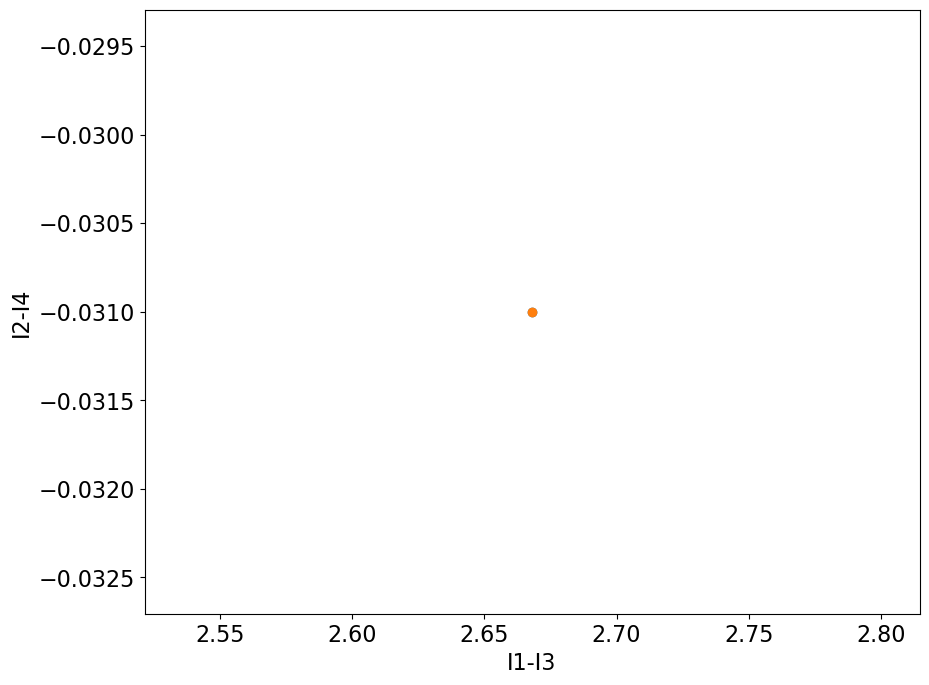

In [1149]:
pl.scatter(spitzer['_3.6mag'] - spitzer['_5.8mag'],  spitzer['_4.5mag'] - spitzer['_8.0mag'])
pl.scatter(spitzer['_3.6mag'][inds_green] - spitzer['_5.8mag'][inds_green],  spitzer['_4.5mag'][inds_green] - spitzer['_8.0mag'][inds_green])

pl.xlabel("I1-I3")
pl.ylabel("I2-I4")

# SEDs again

In [1150]:
import sys, imp
sys.path.append(f'{basepath}/analysis/')
import plot_tools
imp.reload(plot_tools)
from plot_tools import starzoom, make_sed

/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/astropy/units/quantity.py:502: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  value = np.array(value, dtype=dtype, copy=copy, order=order,


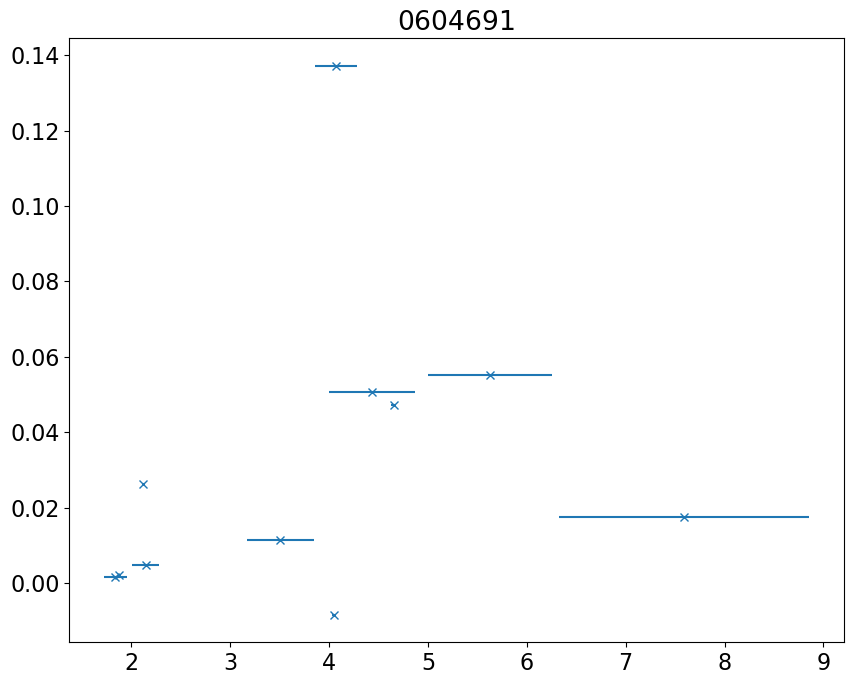

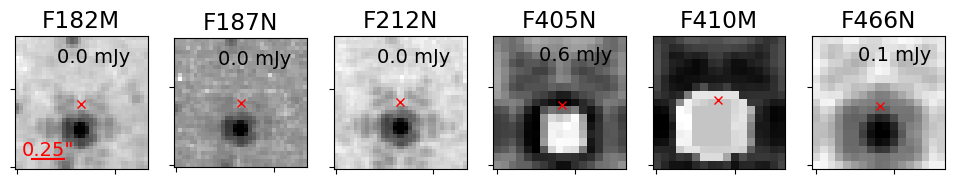

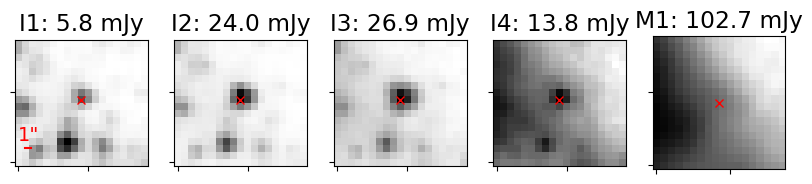

In [1152]:
selstar = spitzer[reddish_i1i2_spitzer_and_greeni2i4][0]
coord = SkyCoord(selstar['RAJ2000'], selstar['DEJ2000'], frame='fk5', unit=(u.h, u.deg))
wavelengths, widths, fluxes, lims = make_sed(coord, basetable=basetable, radius=1*u.arcsec)
pl.errorbar(u.Quantity(wavelengths, u.um), u.Quantity([u.Quantity(x, u.Jy) for x in fluxes], u.Jy),
            xerr=[w/2 for w in widths], linestyle='none', marker='x')
pl.title(starid)
starzoom_(coord)

## Exploration of saturated photometry so I can merge it


This is just doodling at the terminal and can be ignored, but I didn't want to delete it...

In [1155]:
filtername ='f410m'
satstar_cat_fn = f'{basepath}/{filtername.upper()}/pipeline/jw02221-o001_t001_nircam_clear-{filtername}-merged_i2d_satstar_catalog.fits'
satstar_cat = Table.read(satstar_cat_fn)
satstar_coords = satstar_cat['skycoord_fit']


In [1156]:
coord = greenstarregcenters[0]
radius = 0.2*u.arcsec
skycrds_cat = basetable['skycoord_f410m']
idx = coord.separation(skycrds_cat) < radius
print(np.where(idx))
idxsat = coord.separation(satstar_coords) < radius
print(np.where(idxsat), coord.separation(satstar_coords)[idxsat].to(u.arcsec))
basetable[idx]

(array([68296]),)
(array([152]),) [0.00616871arcsec]


<Table length=1>
     x_f410m           y_f410m      flux_f410m passno_f410m   dx_f410m    dy_f410m  dflux_f410m  qf_f410m  rchi2_f410m ... replaced_saturated_f182m flux_jy_410m405 mag_ab_410m405 flux_jy_405m410 mag_ab_405m410 flux_jy_182m187 mag_ab_182m187 flux_jy_187m182 mag_ab_187m182
                                                                                                                       ...                                 Jy                             Jy                             Jy                             Jy                     
     float64           float64       float32     float64      float32     float32     float32    float32     float32   ...           bool               float32        float32         float32        float32         float32        float32         float32        float32    
----------------- ----------------- ---------- ------------ ----------- ----------- ----------- ---------- ----------- ... ------------------------ --------------- -------------- --------------- -------------- --------------- -------------- --------------- --------------
4163.055053889751 1263.620086312294  417316.66          0.0 0.000246156 0.000343037   5970.9844 0.08165585    97030.82 ...                    False      0.13853689      11.046086     -0.14693102             --    0.0013110723      16.105934    0.0007297561      16.742056

In [1157]:
satstar_cat[152]

<Row index=152>
  x_0          y_0               flux_0        id  group_id       x_fit             y_fit            flux_fit                  skycoord_fit                   flux_unc           x_0_unc             y_0_unc       
                                                                                                                                 deg,deg                                                                           
float64      float64            float64      int64  int64        float64           float64           float64                     SkyCoord                     float64            float64             float64       
------- ------------------ ----------------- ----- -------- ----------------- ----------------- ----------------- -------------------------------------- ----------------- ------------------- --------------------
 4162.5 1263.1052631578948 63286.79930672586    79       79 4162.686435830382 1263.157406778175 417316.6587628035 266.53713702824916,-28.689588259846996 5970.984231353989 0.03232633017608248 0.029292964290171565